Notebook to analyze the performance of the invertible neural network trained with dvar = (Vtot, Rmedian, GSD, n, k), qoi = (F11, PPF)

In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
import PyMieScatt as pms
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score#,mean_absolute_percentage_error

In [2]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [3]:
# Path to the file, where the test data are stored
test_datafile = '/data/project/general/aerosolretriev/aerosol_data/dataset_08_11_2022/data_all_test_iv.h5'



In [184]:
model_name = 'invertible_model'
#val_model_name = 'forward_model'

In [185]:
# directory, where the model is stored
directory = '/data/project/general/aerosolretriev/aerosol_results_november_2022/results_08_11_2022/invertible_model1_ds_08_11'

# here the plots of this notebook will be stored
plot_dir = directory +'/plots/model'

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [186]:
# the directory, where the neural network model is stored
model_dir = directory + '/models'


# Load the model and the data (dvar, qoi) for testing

In [187]:
# Load the model
custom_objects = {'AdjustedRSquared': AdjustedRSquared}

kwargs = {'custom_objects': custom_objects,'compile': False}

surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

In [188]:
# Load the test data
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

In [189]:
dvar_test.values

array([[ 2.28059297,  6.60794124, -0.15009153, -1.71783429,  0.45542628],
       [ 1.60000246,  6.10278181, -0.37490623,  0.25680299, -0.28209353],
       [ 2.28782941,  7.99061445,  0.49187971, -0.2771068 ,  0.58076125],
       ...,
       [ 2.19618878,  6.26924431, -0.0516197 ,  0.30707813,  0.6280669 ],
       [ 7.76940559,  6.65941159,  0.4419882 ,  0.38988244, -0.619758  ],
       [ 4.43558706,  5.12772265,  0.45734477,  0.20972751,  0.09901828]])

In [190]:
qoi_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      3.520372  3.370919  3.223337  3.078055  2.935392  2.795585  2.658810   
1      2.993383  2.906044  2.816038  2.723926  2.630191  2.535254  2.439479   
2      2.083922  1.867308  1.665001  1.475370  1.297082  1.129031  0.970285   
3      4.631656  4.608993  4.584164  4.557170  4.528009  4.496681  4.463187   
4      5.166876  5.061900  4.958952  4.858128  4.759479  4.663025  4.568766   
...         ...       ...       ...       ...       ...       ...       ...   
19995  8.967994  8.912232  8.855130  8.796952  8.737918  8.678210  8.617980   
19996  2.485260  2.468145  2.449422  2.429098  2.407180  2.383675  2.358593   
19997  3.508680  3.401139  3.294218  3.188264  3.083539  2.980245  2.878532   
19998  8.758696  8.629973  8.506614  8.388176  8.274274  8.164572  8.058773   
19999  5.462620  5.418097  5.373526  5.329017  5.284647  5.240477  5.196556   

         F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0      2.525198  2.394844  2.267817  ...  0.025432  0.023474  0.021552   
1      2.343187  2.246660  2.150146  ...  0.032973  0.030442  0.027918   
2      0.820055  0.677661  0.542517  ...  0.018595  0.017020  0.015502   
3      4.427529  4.389708  4.349729  ...  0.033449  0.033608  0.033061   
4      4.476688  4.386768  4.298978  ...  0.034360  0.031700  0.029060   
...         ...       ...       ...  ...       ...       ...       ...   
19995  8.557358  8.496452  8.435355  ...  0.061744  0.055834  0.050172   
19996  2.331944  2.303737  2.273986  ...  0.058451  0.053110  0.047927   
19997  2.778518  2.680291  2.583919  ...  0.030253  0.028088  0.025911   
19998  7.956617  7.857872  7.762334  ...  0.033731  0.030741  0.027837   
19999  5.152917  5.109587  5.066588  ...  0.049745  0.044876  0.040226   

        PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0      0.019666  0.017814  0.015998  0.014222  0.012492  0.010814  0.009200  
1      0.025410  0.022931  0.020492  0.018108  0.015795  0.013569  0.011450  
2      0.014041  0.012637  0.011287  0.009990  0.008745  0.007557  0.006427  
3      0.031898  0.030215  0.028111  0.025682  0.023025  0.020230  0.017385  
4      0.026447  0.023871  0.021344  0.018878  0.016487  0.014186  0.011993  
...         ...       ...       ...       ...       ...       ...       ...  
19995  0.044766  0.039624  0.034753  0.030163  0.025863  0.021862  0.018169  
19996  0.042922  0.038115  0.033522  0.029164  0.025055  0.021213  0.017653  
19997  0.023727  0.021547  0.019380  0.017238  0.015136  0.013091  0.011119  
19998  0.025027  0.022317  0.019717  0.017235  0.014880  0.012662  0.010591  
19999  0.035801  0.031608  0.027653  0.023941  0.020478  0.017269  0.014319  

[20000 rows x 304 columns]

In [191]:
qoi_test.describe()

F11_10        F11_11        F11_12        F11_13        F11_14  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       4.745280      4.598268      4.458331      4.325928      4.200499   
std        2.665670      2.692795      2.719803      2.744343      2.767103   
min       -3.038451     -3.000078     -3.677873     -3.941128     -3.619981   
25%        2.601702      2.461499      2.314533      2.187715      2.070506   
50%        4.735658      4.589805      4.453887      4.323017      4.199870   
75%        6.920807      6.780902      6.644190      6.514823      6.389499   
max       10.596831     10.573233     10.547368     10.519230     10.488816   

             F11_15        F11_16        F11_17        F11_18        F11_19  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       4.080411      3.965383      3.855518      3.750109      3.649078   
std        2.788244      2.807845      2.826382      2.844244      2.860974   
min       -3.683784     -3.822893     -4.210827     -4.113702     -4.228093   
25%        1.946160      1.831749      1.728889      1.621111      1.522161   
50%        4.081967      3.966829      3.857322      3.753065      3.648350   
75%        6.276201      6.166499      6.062248      5.966131      5.877313   
max       10.456121     10.421140     10.383871     10.344309     10.302454   

       ...       PPF_161       PPF_162       PPF_163       PPF_164  \
count  ...  20000.000000  20000.000000  20000.000000  20000.000000   
mean   ...      0.031286      0.028677      0.026149      0.023700   
std    ...      0.036383      0.034496      0.032627      0.030764   
min    ...     -0.853029     -0.862604     -0.853717     -0.826214   
25%    ...      0.020564      0.018737      0.016992      0.015307   
50%    ...      0.031923      0.029399      0.026907      0.024449   
75%    ...      0.044761      0.040795      0.036905      0.033111   
max    ...      0.762965      0.772958      0.759170      0.723424   

            PPF_165       PPF_166       PPF_167       PPF_168       PPF_169  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.021331      0.019046      0.016852      0.014757      0.012766   
std        0.028862      0.026888      0.024845      0.022757      0.020652   
min       -0.781456     -0.722156     -0.651970     -0.574968     -0.495129   
25%        0.013688      0.012133      0.010670      0.009278      0.007962   
50%        0.022112      0.019765      0.017487      0.015268      0.013139   
75%        0.029431      0.025936      0.022627      0.019479      0.016538   
max        0.759795      0.782100      0.768775      0.722903      0.651566   

            PPF_170  
count  20000.000000  
mean       0.010878  
std        0.018548  
min       -0.415962  
25%        0.006735  
50%        0.011106  
75%        0.013813  
max        0.564333  

[8 rows x 304 columns]

In [192]:
qoi_columns = qoi_test.columns
dvar_columns = dvar_test.columns

In [193]:
qoi_test_plot = qoi_test.copy()

In [203]:
dvar_test = np.exp(dvar_test)
dvar_test['GSD']=dvar_test['GSD']+1
dvar_test['n']=dvar_test['n']+1.33

In [205]:
dvar_test.sort_values('GSD')

Vtot     RmedianV       GSD         n         k
5969   1575.665513   253.993038  1.001019  1.428218  1.624365
17576     1.124210  2674.372327  1.001189  1.894911  0.823388
14877    17.305029   301.665800  1.001278  2.577000  1.387965
16478   330.485960   545.798124  1.001378  1.483720  0.922275
2470      2.910424   208.108089  1.001417  1.546125  1.216770
...            ...          ...       ...       ...       ...
2046      2.834607  3296.731131  2.999285  2.910365  1.692498
5723     11.133328   124.448209  2.999409  1.849896  0.629295
14823     2.003285  1569.451763  2.999501  1.822275  2.048765
1201      6.116136  2805.536699  2.999604  2.739186  0.367381
16095   297.790444  2939.151920  2.999704  1.712841  0.731974

[20000 rows x 5 columns]

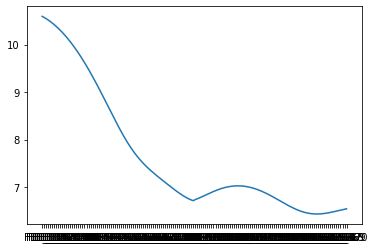

In [206]:
plt.figure()
plt.plot(qoi_test_plot[F11_list].loc[5969])

# Prediction

## Forward Prediction

In [195]:
import time
start = time.time()
qoi_pred_fw = surr.predict(dvar_test.values)
end = time.time()
time = (end-start)/len(dvar_test)
time

0.00023031195402145385

In [196]:
qoi_columns

Index(['F11_10', 'F11_11', 'F11_12', 'F11_13', 'F11_14', 'F11_15', 'F11_16',
       'F11_17', 'F11_18', 'F11_19',
       ...
       'PPF_161', 'PPF_162', 'PPF_163', 'PPF_164', 'PPF_165', 'PPF_166',
       'PPF_167', 'PPF_168', 'PPF_169', 'PPF_170'],
      dtype='object', length=304)

In [197]:
qoi_pred_fw.shape

(20000, 304)

In [198]:
qoi_pred_fw = pd.DataFrame(data=qoi_pred_fw, columns=qoi_columns)
qoi_pred_fw

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      3.471372  3.449748  3.077947  3.127223  3.007990  2.946875  2.762536   
1      3.060793  2.940143  2.766819  2.782215  2.680710  2.609580  2.409728   
2      2.008867  1.808686  1.550495  1.474350  1.290321  1.101151  0.938648   
3      5.587588  4.793044  4.471786  4.892773  4.808953  5.713886  4.797375   
4      5.234840  5.117166  4.865404  4.957440  4.870614  4.872031  4.728499   
...         ...       ...       ...       ...       ...       ...       ...   
19995  9.189890  9.109672  9.160372  8.796153  8.780161  8.670675  8.664630   
19996  2.709636  2.412473  2.415342  2.512714  2.493437  2.850828  2.310639   
19997  3.515019  3.389674  3.116845  3.155496  3.126500  3.090335  2.916815   
19998  8.755365  8.641343  8.626804  8.488755  8.382289  8.263908  8.103580   
19999  5.547649  5.515197  5.517312  5.423968  5.366227  5.303812  5.293979   

         F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0      2.561925  2.461666  2.347330  ...  0.024826  0.023378  0.020253   
1      2.200733  2.246000  2.093897  ...  0.034080  0.030271  0.028345   
2      0.650747  0.600529  0.422360  ...  0.016930  0.015764  0.013895   
3      6.093429  5.175221  4.750880  ... -0.033230 -0.030564 -0.028213   
4      4.490235  4.533500  4.419447  ...  0.034991  0.032362  0.029775   
...         ...       ...       ...  ...       ...       ...       ...   
19995  8.983606  8.729542  8.730413  ...  0.062785  0.057336  0.051889   
19996  2.245205  2.329218  2.420591  ...  0.055104  0.052431  0.045422   
19997  2.631807  2.752273  2.645446  ...  0.030531  0.027566  0.026003   
19998  8.000919  8.063187  7.804541  ...  0.036054  0.033130  0.030020   
19999  5.353174  5.286933  5.224483  ...  0.050085  0.045622  0.040714   

        PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0      0.019496  0.017316  0.015354  0.014130  0.012010  0.010686  0.008921  
1      0.025295  0.023221  0.020812  0.018253  0.015747  0.013739  0.011710  
2      0.012855  0.010905  0.009252  0.007823  0.007667  0.006738  0.005192  
3     -0.021637 -0.018971 -0.017549 -0.011848 -0.009011 -0.005098 -0.002210  
4      0.026767  0.023879  0.021777  0.018785  0.016623  0.013950  0.012031  
...         ...       ...       ...       ...       ...       ...       ...  
19995  0.046626  0.041724  0.036552  0.031285  0.026985  0.022658  0.019005  
19996  0.041228  0.037415  0.030077  0.027866  0.021619  0.018460  0.013863  
19997  0.023483  0.022004  0.019225  0.017108  0.014978  0.012930  0.010618  
19998  0.026709  0.023287  0.020572  0.018299  0.015414  0.013356  0.011522  
19999  0.036185  0.032137  0.028041  0.023949  0.020636  0.017056  0.014372  

[20000 rows x 304 columns]

In [199]:
#qoi_pred_plot_fw



In [200]:
# find columns, that belong to F11 and PPF
F11_list = [x for x in qoi_pred_fw.columns if 'F11' in x]
PPF_list = [x for x in qoi_pred_fw.columns if 'PPF' in x]
F11_list

['F11_10',
 'F11_11',
 'F11_12',
 'F11_13',
 'F11_14',
 'F11_15',
 'F11_16',
 'F11_17',
 'F11_18',
 'F11_19',
 'F11_20',
 'F11_21',
 'F11_22',
 'F11_23',
 'F11_24',
 'F11_25',
 'F11_26',
 'F11_27',
 'F11_28',
 'F11_29',
 'F11_30',
 'F11_31',
 'F11_32',
 'F11_33',
 'F11_34',
 'F11_35',
 'F11_36',
 'F11_37',
 'F11_38',
 'F11_39',
 'F11_40',
 'F11_41',
 'F11_42',
 'F11_43',
 'F11_44',
 'F11_45',
 'F11_46',
 'F11_47',
 'F11_48',
 'F11_49',
 'F11_50',
 'F11_51',
 'F11_52',
 'F11_53',
 'F11_54',
 'F11_55',
 'F11_56',
 'F11_57',
 'F11_58',
 'F11_59',
 'F11_60',
 'F11_61',
 'F11_62',
 'F11_63',
 'F11_64',
 'F11_65',
 'F11_66',
 'F11_67',
 'F11_68',
 'F11_69',
 'F11_70',
 'F11_71',
 'F11_72',
 'F11_73',
 'F11_74',
 'F11_75',
 'F11_76',
 'F11_77',
 'F11_78',
 'F11_79',
 'F11_80',
 'F11_81',
 'F11_82',
 'F11_83',
 'F11_84',
 'F11_85',
 'F11_95',
 'F11_96',
 'F11_97',
 'F11_98',
 'F11_99',
 'F11_100',
 'F11_101',
 'F11_102',
 'F11_103',
 'F11_104',
 'F11_105',
 'F11_106',
 'F11_107',
 'F11_108',
 

# Redo manual preprocessing qoi

In [20]:
qoi_pred_plot_fw = qoi_pred_fw.copy()
qoi_pred_plot_fw[F11_list] = np.exp(qoi_pred_plot_fw[F11_list])


In [192]:
qoi_test_plot = qoi_test.copy()
qoi_test_plot[F11_list] = np.exp(qoi_test_plot[F11_list])


In [193]:
qoi_test_plot

F11_10       F11_11       F11_12       F11_13       F11_14  \
0        33.797001    29.105276    25.111787    21.716133    18.828887   
1        19.953079    18.284314    16.710513    15.240040    13.876427   
2         8.035923     6.470855     5.285677     4.372651     3.658605   
3       102.683974   100.382995    97.921331    95.313353    92.574044   
4       175.366098   157.890192   142.444406   128.782884   116.685096   
...            ...          ...          ...          ...          ...   
19995  7847.839536  7422.210700  7010.259771  6614.053988  6234.899750   
19996    12.004246    11.800541    11.581655    11.348642    11.102603   
19997    33.404134    29.998255    26.956325    24.246293    21.835550   
19998  6365.807919  5596.929582  4947.382325  4394.793655  3921.674979   
19999   235.714271   225.449582   215.621769   206.235050   197.284460   

            F11_15       F11_16       F11_17       F11_18       F11_19  ...  \
0        16.372200    14.279283    12.493366    10.966491     9.658293  ...   
1        12.619634    11.467066    10.414378     9.456102     8.586113  ...   
2         3.092657     2.638697     2.270625     1.969266     1.720331  ...   
3        89.718860    86.763596    83.724245    80.616864    77.457437  ...   
4       105.956089    96.425009    87.942888    80.380212    73.624530  ...   
...            ...          ...          ...          ...          ...  ...   
19995  5873.521517  5530.205872  5204.913448  4897.364118  4607.104574  ...   
19996    10.844684    10.576061    10.297938    10.011531     9.718064  ...   
19997    19.692632    17.788137    16.095144    14.589337    13.248965  ...   
19998  3514.216268  3161.408841  2854.399928  2586.012340  2350.383309  ...   
19999   188.760139   180.648937   172.935168   165.601973   158.632143  ...   

        PPF_161   PPF_162   PPF_163   PPF_164   PPF_165   PPF_166   PPF_167  \
0      0.025432  0.023474  0.021552  0.019666  0.017814  0.015998  0.014222   
1      0.032973  0.030442  0.027918  0.025410  0.022931  0.020492  0.018108   
2      0.018595  0.017020  0.015502  0.014041  0.012637  0.011287  0.009990   
3      0.033449  0.033608  0.033061  0.031898  0.030215  0.028111  0.025682   
4      0.034360  0.031700  0.029060  0.026447  0.023871  0.021344  0.018878   
...         ...       ...       ...       ...       ...       ...       ...   
19995  0.061744  0.055834  0.050172  0.044766  0.039624  0.034753  0.030163   
19996  0.058451  0.053110  0.047927  0.042922  0.038115  0.033522  0.029164   
19997  0.030253  0.028088  0.025911  0.023727  0.021547  0.019380  0.017238   
19998  0.033731  0.030741  0.027837  0.025027  0.022317  0.019717  0.017235   
19999  0.049745  0.044876  0.040226  0.035801  0.031608  0.027653  0.023941   

        PPF_168   PPF_169   PPF_170  
0      0.012492  0.010814  0.009200  
1      0.015795  0.013569  0.011450  
2      0.008745  0.007557  0.006427  
3      0.023025  0.020230  0.017385  
4      0.016487  0.014186  0.011993  
...         ...       ...       ...  
19995  0.025863  0.021862  0.018169  
19996  0.025055  0.021213  0.017653  
19997  0.015136  0.013091  0.011119  
19998  0.014880  0.012662  0.010591  
19999  0.020478  0.017269  0.014319  

[20000 rows x 304 columns]

## Inverse prediction

In [23]:
dvar_pred_iv_original = surr.sample_n_tries(qoi_test.values,batch_size = 8, n_tries = 5)

In [24]:

dvar_pred_iv = pd.DataFrame(data = dvar_pred_iv_original, columns = dvar_test.columns)

In [25]:
dvar_test.describe()

Vtot      RmedianV           GSD             n             k
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       4.228670      6.568305     -0.302624     -0.498653     -0.200180
std        2.463045      1.127070      0.984600      1.001982      0.989845
min        0.000128      4.605258     -6.888993    -12.717562     -8.913004
25%        2.085886      5.584726     -0.682078     -0.892638     -0.584926
50%        4.212666      6.579293     -0.001542     -0.190686      0.105239
75%        6.369368      7.540427      0.404580      0.217854      0.502655
max        8.516872      8.517088      0.692999      0.512770      0.788400

In [26]:
dvar_pred_iv.describe()

Vtot      RmedianV           GSD             n             k
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       4.208314      6.560301     -0.309209     -0.490725     -0.204087
std        2.457222      1.121977      0.967037      0.981141      0.977143
min       -0.532321      4.442027     -6.967933     -6.036449     -8.709739
25%        2.062517      5.578384     -0.708481     -0.895249     -0.591900
50%        4.195682      6.583663     -0.010179     -0.180924      0.097872
75%        6.345987      7.537956      0.402169      0.223119      0.491416
max        9.227142      9.688653      0.775482      0.953945      1.414060

# Redo manual preprocessing dvar

In [27]:
#dvar_pred_iv['k']=dvar_pred_iv['k']
#dvar_test['k']=dvar_test['k']

In [28]:
#dvar_test['Vtot']=np.exp(dvar_test['Vtot'])
dvar_test['RmedianV'] = np.exp(dvar_test['RmedianV'])
dvar_test['GSD']=np.exp(dvar_test['GSD'])+1
dvar_test['n'] = np.exp(dvar_test['n'])+1.33
dvar_test['k']=np.exp(dvar_test['k'])


In [29]:
#dvar_pred_iv['Vtot']=np.exp(dvar_pred_iv['Vtot'])
dvar_pred_iv['RmedianV'] = np.exp(dvar_pred_iv['RmedianV'])
dvar_pred_iv['GSD']=np.exp(dvar_pred_iv['GSD'])+1
dvar_pred_iv['n'] = np.exp(dvar_pred_iv['n'])+1.33
dvar_pred_iv['k']=np.exp(dvar_pred_iv['k'])


In [30]:
dvar_test.describe()

Vtot      RmedianV           GSD             n             k
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       4.228670   1255.382437      1.999385      2.158650      1.105898
std        2.463045   1268.892038      0.574752      0.482531      0.632708
min        0.000128    100.008814      1.001019      1.330003      0.000135
25%        2.085886    266.327266      1.505565      1.739574      0.557147
50%        4.212666    720.029887      1.998460      2.156392      1.110976
75%        6.369368   1882.633034      2.498673      2.573405      1.653105
max        8.516872   4999.474451      2.999704      2.999911      2.199874

In [31]:
dvar_pred_iv.describe()

Vtot      RmedianV           GSD             n             k
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       4.208314   1233.943320      1.989470      2.164191      1.097270
std        2.457222   1226.755262      0.570529      0.488309      0.627087
min       -0.532321     84.946972      1.000942      1.332390      0.000165
25%        2.062517    264.643513      1.492392      1.738506      0.553275
50%        4.195682    723.183475      1.989872      2.164498      1.102822
75%        6.345987   1877.987610      2.495063      2.579969      1.634630
max        9.227142  16133.490121      3.171638      3.925930      4.112618

# Calculate metrics

## R2

Use either R2 or adjusted R2

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$


adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$


In [32]:
qoi_test_copy = qoi_test_plot.copy()
qoi_pred_fw_copy  = qoi_pred_plot_fw.copy()


In [33]:
#qoi_test_copy[F11_list]=np.exp(qoi_test_copy[F11_list])
#qoi_test_copy[PPF_list]=qoi_test_copy[PPF_list]/10.

In [34]:
#qoi_pred_fw_copy[F11_list]=np.exp(qoi_pred_fw_copy[F11_list])
#qoi_pred_fw_copy[PPF_list]=qoi_pred_fw_copy[PPF_list]/10.

In [35]:
#metric_fw = AdjustedRSquaredSeparated(qoi_test.shape[0], qoi_test.shape[1])
metric_fw = RSquaredSeparated()

r2_adj_fw = metric_fw.call(qoi_test_copy.values, qoi_pred_fw_copy.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=qoi_columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
print('Forward model: ','R2_min = ', min(r2_adj_fw.min()),';  R2_max = ', max(r2_adj_fw.max()))

r2_adj_fw

Forward model:  R2_min =  -4629.43 ;  R2_max =  0.99


F11_10  F11_11  F11_12  F11_13  F11_14   F11_15  F11_16  F11_17  F11_18  \
0    0.74    -3.6    0.92    0.54   -0.61 -4168.87   -0.11  -31.76    0.66   

   F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  PPF_167  \
0    0.88  ...     0.74     0.74     0.72     0.72     0.72     0.73     0.74   

   PPF_168  PPF_169  PPF_170  
0     0.76     0.78     0.78  

[1 rows x 304 columns]

In [36]:
r2_adj_fw.sort_values(by=r2_adj_fw.index[0], axis = 1,ascending=True)

F11_144   F11_15  F11_125  F11_36  F11_109  F11_30  F11_159  F11_17  \
0 -4629.43 -4168.87  -974.93 -393.98  -228.36  -66.83   -34.34  -31.76   

   F11_167  F11_108  ...  PPF_52  PPF_50  PPF_49  PPF_48  PPF_47  PPF_46  \
0    -5.58    -3.63  ...    0.99    0.99    0.99    0.99    0.99    0.99   

   PPF_45  PPF_44  PPF_51  PPF_36  
0    0.99    0.99    0.99    0.99  

[1 rows x 304 columns]

In [37]:
print('Forward model: ','R2_min = ', min(r2_adj_fw.min()),';  R2_max = ', max(r2_adj_fw.max()))

r2_adj_fw.mean(axis = 1)

Forward model:  R2_min =  -4629.43 ;  R2_max =  0.99


0   -33.861513
dtype: float64

In [38]:
dvar_test_copy = dvar_test.copy()
dvar_pred_iv_copy = dvar_pred_iv.copy()

In [39]:
#metric_iv = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])
metric_iv = RSquaredSeparated()

r2_adj_iv = metric_iv.call(dvar_test_copy.values, dvar_pred_iv_copy.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=dvar_columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Inverse model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))

r2_adj_iv

Inverse model:  R2_min =  0.98 ;  R2_max =  1.0


Vtot  RmedianV   GSD     n     k
0   1.0      0.98  0.99  0.98  0.98

In [40]:
np.mean(r2_adj_iv, axis = 1)

0    0.986
dtype: float64

# Relative and absolute error

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

absolute_error = $|y_{true}-y_{pred}|$

be careful, if $y_{true}$ is very small


In [41]:
abs_error_fw = np.abs( qoi_test_copy - qoi_pred_fw_copy)
abs_error_fw

F11_10       F11_11       F11_12      F11_13      F11_14  \
0         1.433933     1.700909     3.937989    0.614436    0.953141   
1         3.036463     1.990058     0.218718    0.994265    0.997169   
2         0.174101     0.311042     0.354732    0.059185    0.126831   
3       151.109509    19.433925     8.535195   41.177784   29.151707   
4         3.959048     3.789358    13.006373   12.521344   11.961676   
...            ...          ...          ...         ...         ...   
19995  2037.992380  1752.346572  2826.102196  288.124679  445.242874   
19996     3.783778     0.959033     0.358014    0.881742    0.726120   
19997     0.136349     0.174542     3.076822    0.923239    1.303625   
19998    52.530306    43.025833   601.924570  542.292493  559.250371   
19999    27.726600    16.972088    31.599080   20.023445   16.484703   

           F11_15      F11_16       F11_17       F11_18       F11_19  ...  \
0        2.408748    0.893887     0.285561     0.587092     0.763384  ...   
1        1.575092    0.117903     1.083703     0.814511     0.070962  ...   
2        0.100623    0.028579     0.185042     0.034474     0.048542  ...   
3      208.828754   34.241580   361.435531    88.913774    31.895785  ...   
4       22.834950   13.428209     2.592984     9.779781     6.884711  ...   
...           ...         ...          ...          ...          ...  ...   
19995  139.426330  405.528696  2997.719563  1348.577078  1759.938514  ...   
19996    7.246230    0.596781     0.923505     0.468198     1.509290  ...   
19997    3.754596    0.858862     1.664231     0.892774     1.144539  ...   
19998  404.785378  223.446559   339.085407   434.829709   187.092190  ...   
19999   14.973289   18.089081    36.173607    36.360169    29.389613  ...   

        PPF_161   PPF_162   PPF_163   PPF_164   PPF_165   PPF_166   PPF_167  \
0      0.000110  0.000185  0.000536  0.000464  0.000558  0.000389  0.000250   
1      0.000405  0.000205  0.000637  0.000242  0.000126  0.000317  0.000336   
2      0.001325  0.001389  0.001459  0.001485  0.000997  0.001280  0.001583   
3      0.059817  0.058637  0.055215  0.048451  0.044389  0.039723  0.033365   
4      0.000626  0.000789  0.000569  0.000750  0.000286  0.000008  0.000158   
...         ...       ...       ...       ...       ...       ...       ...   
19995  0.000654  0.000817  0.000809  0.001655  0.001480  0.001106  0.000545   
19996  0.003257  0.001133  0.001812  0.002094  0.000944  0.003045  0.001169   
19997  0.000005  0.000077  0.000348  0.000202  0.000438  0.000243  0.000063   
19998  0.002229  0.002485  0.001594  0.001437  0.000950  0.001031  0.001045   
19999  0.000717  0.000423  0.000889  0.000287  0.000468  0.000058  0.000011   

        PPF_168   PPF_169   PPF_170  
0      0.000493  0.000263  0.000026  
1      0.000489  0.000676  0.000607  
2      0.001116  0.000610  0.000774  
3      0.028264  0.022305  0.017348  
4      0.000262  0.000011  0.000050  
...         ...       ...       ...  
19995  0.000570  0.000588  0.000563  
19996  0.003680  0.003088  0.003569  
19997  0.000152  0.000120  0.000187  
19998  0.000530  0.000822  0.000663  
19999  0.000088  0.000181  0.000386  

[20000 rows x 304 columns]

In [42]:
#rel_error_fw.iloc[6401]['P12_0.532_156'] = 9789120.031523209
# diff_fw.iloc[6401]['P12_0.532_156'] = -0.017945414841788347
# qoi_test.iloc[6401]['P12_0.532_156'] = -1.9332e-07
# qoi_pred_fw.iloc[6401]['P12_0.532_156'] = 0.017945221521788346

In [43]:
rel_error_fw = abs_error_fw / (qoi_test_copy) * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=qoi_columns).abs()

In [44]:
#qoi_test.to_csv(f'{plot_dir}/qoi_test.csv')

In [45]:
#qoi_pred_fw.to_csv(f'{plot_dir}/qoi_pred_fw.csv')

In [46]:
abs_error_table_fw =  np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

F11_10   F11_11   F11_12   F11_13   F11_14   F11_15   F11_16   F11_17  \
50%    14.72    11.99    11.34     8.13     6.83     7.24     6.13     5.83   
75%   191.10   164.49   120.06   110.40    93.90    87.86    87.09    74.41   
90%   898.68   836.02   581.65   571.10   530.69   475.91   514.49   459.55   
95%  1896.02  1734.05  1198.02  1090.99  1091.71  1059.42  1110.45  1072.84   
99%  5852.51  5776.88  3119.34  2817.51  2961.90  3940.67  3569.83  3193.15   

      F11_18   F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  \
50%     5.91     4.30  ...     0.00     0.00     0.00     0.00     0.00   
75%    81.51    58.07  ...     0.00     0.00     0.00     0.00     0.00   
90%   513.24   366.84  ...     0.00     0.00     0.00     0.00     0.00   
95%  1143.54   840.20  ...     0.01     0.01     0.01     0.01     0.01   
99%  3164.70  2311.69  ...     0.04     0.03     0.03     0.03     0.03   

     PPF_166  PPF_167  PPF_168  PPF_169  PPF_170  
50%     0.00     0.00     0.00     0.00     0.00  
75%     0.00     0.00     0.00     0.00     0.00  
90%     0.00     0.00     0.00     0.00     0.00  
95%     0.01     0.01     0.00     0.00     0.00  
99%     0.03     0.02     0.02     0.02     0.02  

[5 rows x 304 columns]

In [47]:
abs_error_table_fw

F11_10   F11_11   F11_12   F11_13   F11_14   F11_15   F11_16   F11_17  \
50%    14.72    11.99    11.34     8.13     6.83     7.24     6.13     5.83   
75%   191.10   164.49   120.06   110.40    93.90    87.86    87.09    74.41   
90%   898.68   836.02   581.65   571.10   530.69   475.91   514.49   459.55   
95%  1896.02  1734.05  1198.02  1090.99  1091.71  1059.42  1110.45  1072.84   
99%  5852.51  5776.88  3119.34  2817.51  2961.90  3940.67  3569.83  3193.15   

      F11_18   F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  \
50%     5.91     4.30  ...     0.00     0.00     0.00     0.00     0.00   
75%    81.51    58.07  ...     0.00     0.00     0.00     0.00     0.00   
90%   513.24   366.84  ...     0.00     0.00     0.00     0.00     0.00   
95%  1143.54   840.20  ...     0.01     0.01     0.01     0.01     0.01   
99%  3164.70  2311.69  ...     0.04     0.03     0.03     0.03     0.03   

     PPF_166  PPF_167  PPF_168  PPF_169  PPF_170  
50%     0.00     0.00     0.00     0.00     0.00  
75%     0.00     0.00     0.00     0.00     0.00  
90%     0.00     0.00     0.00     0.00     0.00  
95%     0.01     0.01     0.00     0.00     0.00  
99%     0.03     0.02     0.02     0.02     0.02  

[5 rows x 304 columns]

In [48]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%   14.51   13.88   14.78   11.74   11.57   12.94   12.34   15.43   15.58   
75%   30.14   26.72   31.58   19.21   19.32   21.80   20.94   29.73   24.42   
90%   51.60   47.65   62.28   29.06   31.22   35.40   34.25   46.67   34.54   
95%   75.60   72.65   90.98   41.34   42.13   52.25   50.08   60.24   45.55   
99%  172.34  194.92  184.13   95.42   87.69  145.22  120.55  156.56  124.89   

     F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  \
50%   12.51  ...     2.68     3.03     2.93     2.94     2.95     3.26   
75%   20.99  ...     5.47     6.27     5.97     6.17     6.47     7.45   
90%   31.00  ...    11.59    11.76    11.70    11.87    12.98    13.85   
95%   40.50  ...    21.40    20.68    20.16    19.99    20.72    22.09   
99%   93.03  ...   133.03   121.11   120.29   116.16   122.17   120.55   

     PPF_167  PPF_168  PPF_169  PPF_170  
50%     3.44     3.48     3.61     4.14  
75%     7.65     7.70     8.24     9.29  
90%    14.02    15.28    17.04    17.58  
95%    21.84    26.63    27.50    27.86  
99%   119.20   113.67   115.46   127.48  

[5 rows x 304 columns]

In [49]:
rel_error_table_fw.sort_values(by=rel_error_table_fw.index[3], axis = 1,ascending=False)

PPF_10  F11_144  F11_12  F11_164  F11_10  F11_11  PPF_11  F11_138  \
50%     7.57    19.21   14.78    13.22   14.51   13.88    4.14    19.51   
75%    26.70    37.30   31.58    29.00   30.14   26.72   10.12    33.20   
90%    97.45    71.31   62.28    61.48   51.60   47.65   33.09    50.39   
95%   345.05   119.99   90.98    88.72   75.60   72.65   70.83    63.27   
99%  2847.49   267.89  184.13   171.52  172.34  194.92  405.31    88.83   

     PPF_12  F11_17  ...  PPF_68  PPF_66  PPF_62  PPF_57  PPF_64  PPF_71  \
50%    3.32   15.43  ...    1.45    1.50    1.59    1.64    1.52    1.46   
75%    8.36   29.73  ...    2.73    2.85    3.00    3.16    2.82    2.72   
90%   27.68   46.67  ...    5.78    5.97    5.83    6.47    5.96    5.80   
95%   60.77   60.24  ...   15.25   15.03   14.83   14.79   14.78   14.78   
99%  403.45  156.56  ...  113.42  112.90  106.21   99.58  109.65   94.14   

     PPF_65  PPF_60  PPF_67  PPF_63  
50%    1.52    1.59    1.49    1.46  
75%    2.88    3.03    2.71    2.77  
90%    6.05    6.04    5.65    5.58  
95%   14.68   14.51   14.46   14.29  
99%  110.80  110.30  107.49  103.28  

[5 rows x 304 columns]

In [50]:
rel_error_table_fw_copy = rel_error_table_fw.copy()
rel_error_table_fw_copy.drop(['PPF_10'], axis = 1)


F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%   14.51   13.88   14.78   11.74   11.57   12.94   12.34   15.43   15.58   
75%   30.14   26.72   31.58   19.21   19.32   21.80   20.94   29.73   24.42   
90%   51.60   47.65   62.28   29.06   31.22   35.40   34.25   46.67   34.54   
95%   75.60   72.65   90.98   41.34   42.13   52.25   50.08   60.24   45.55   
99%  172.34  194.92  184.13   95.42   87.69  145.22  120.55  156.56  124.89   

     F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  \
50%   12.51  ...     2.68     3.03     2.93     2.94     2.95     3.26   
75%   20.99  ...     5.47     6.27     5.97     6.17     6.47     7.45   
90%   31.00  ...    11.59    11.76    11.70    11.87    12.98    13.85   
95%   40.50  ...    21.40    20.68    20.16    19.99    20.72    22.09   
99%   93.03  ...   133.03   121.11   120.29   116.16   122.17   120.55   

     PPF_167  PPF_168  PPF_169  PPF_170  
50%     3.44     3.48     3.61     4.14  
75%     7.65     7.70     8.24     9.29  
90%    14.02    15.28    17.04    17.58  
95%    21.84    26.63    27.50    27.86  
99%   119.20   113.67   115.46   127.48  

[5 rows x 303 columns]

In [51]:
F11_532_columns = []
PPF_532_columns = []
for name in qoi_columns:
    if 'F11' in name:
        F11_532_columns.append(name)
    if 'PPF' in name:
        PPF_532_columns.append(name)

In [52]:
abs_error_table_fw_F11 = abs_error_table_fw[F11_532_columns]
print('Absolute error F11')
print(abs_error_table_fw_F11.max(axis = 1))
abs_error_table_fw_PPF = abs_error_table_fw[PPF_532_columns]
print('Absolute error PPF')
print(abs_error_table_fw_PPF.max(axis = 1))


Absolute error F11
50%      14.72
75%     191.10
90%     898.68
95%    1896.02
99%    5852.51
dtype: float64
Absolute error PPF
50%    0.01
75%    0.01
90%    0.03
95%    0.04
99%    0.14
dtype: float64


In [53]:
rel_error_table_fw_F11 = rel_error_table_fw[F11_532_columns]
print('Relative error F11')
print(rel_error_table_fw_F11.max(axis = 1))
rel_error_table_fw_PPF = rel_error_table_fw[PPF_532_columns]
print('Relative error PPF')
print(rel_error_table_fw_PPF.max(axis = 1))


Relative error F11
50%     19.51
75%     37.30
90%     71.31
95%    119.99
99%    267.89
dtype: float64
Relative error PPF
50%       7.57
75%      26.70
90%      97.45
95%     345.05
99%    2847.49
dtype: float64


In [54]:
print('Forward model: max. abs. error P11/P12')
print(abs_error_table_fw_PPF.max(axis = 1))

Forward model: max. abs. error P11/P12
50%    0.01
75%    0.01
90%    0.03
95%    0.04
99%    0.14
dtype: float64


In [55]:
print('Forward model: max. rel. error in % P11')
print(rel_error_table_fw_F11.max(axis = 1))

Forward model: max. rel. error in % P11
50%     19.51
75%     37.30
90%     71.31
95%    119.99
99%    267.89
dtype: float64


In [56]:
abs_error_iv = np.abs(dvar_test_copy-dvar_pred_iv_copy)
abs_error_iv.mean()

Vtot         0.047149
RmedianV    55.578414
GSD          0.035176
n            0.038241
k            0.043673
dtype: float64

In [57]:
rel_error_iv = abs_error_iv / (dvar_test_copy) * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=dvar_columns).abs()

In [58]:
abs_error_table_iv = np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_iv

Vtot  RmedianV   GSD     n     k
50%  0.03     10.02  0.02  0.03  0.02
75%  0.06     45.63  0.05  0.05  0.05
90%  0.10    144.71  0.08  0.08  0.10
95%  0.14    263.63  0.11  0.11  0.14
99%  0.28    635.16  0.20  0.24  0.30

In [59]:
rel_error_iv.mean()

Vtot        9.283723
RmedianV    2.997420
GSD         1.735863
n           1.718925
k           7.550243
dtype: float64

In [60]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_iv

Vtot  RmedianV    GSD     n      k
50%   0.81      1.81   1.18  1.21   2.90
75%   1.89      3.53   2.19  2.17   5.57
90%   5.21      6.41   3.64  3.49  10.66
95%  11.31      9.16   5.10  4.72  17.40
99%  57.51     18.39  10.78  9.78  53.53

In [61]:
print('Inverse model: max. rel. error in %')
print(rel_error_table_iv.max(axis = 1))

Inverse model: max. rel. error in %
50%     2.90
75%     5.57
90%    10.66
95%    17.40
99%    57.51
dtype: float64


In [62]:
dvar_test.columns

Index(['Vtot', 'RmedianV', 'GSD', 'n', 'k'], dtype='object')

In [33]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [64]:
wMAPE_qoi = wmape(qoi_test_copy, qoi_pred_fw_copy)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
wMAPE_qoi

F11_10     F11_11     F11_12     F11_13     F11_14      F11_15  \
0  28.757473  36.121638  20.087738  21.618818  24.736922  157.494831   

      F11_16     F11_17     F11_18     F11_19  ...   PPF_161   PPF_162  \
0  31.552064  46.008005  31.826713  23.511146  ...  7.884351  8.218728   

   PPF_163   PPF_164   PPF_165   PPF_166   PPF_167   PPF_168    PPF_169  \
0  8.34395  8.525796  8.830911  9.212434  9.561406  9.839198  10.286192   

     PPF_170  
0  11.326269  

[1 rows x 304 columns]

In [65]:
wMAPE_qoi[F11_532_columns].mean().mean()

25.96168934967002

In [66]:
wMAPE_qoi[PPF_532_columns].mean().mean()

3.966667047715518

In [67]:
dvar_pred_iv_copy.describe()

Vtot      RmedianV           GSD             n             k
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       4.208314   1233.943320      1.989470      2.164191      1.097270
std        2.457222   1226.755262      0.570529      0.488309      0.627087
min       -0.532321     84.946972      1.000942      1.332390      0.000165
25%        2.062517    264.643513      1.492392      1.738506      0.553275
50%        4.195682    723.183475      1.989872      2.164498      1.102822
75%        6.345987   1877.987610      2.495063      2.579969      1.634630
max        9.227142  16133.490121      3.171638      3.925930      4.112618

In [68]:
wMAPE_dvar = wmape(dvar_test_copy, dvar_pred_iv_copy)
wMAPE_dvar = pd.DataFrame(wMAPE_dvar).T
wMAPE_dvar

Vtot  RmedianV      GSD         n         k
0  1.114979   4.42721  1.75935  1.771525  3.949096

In [69]:
index = 6899

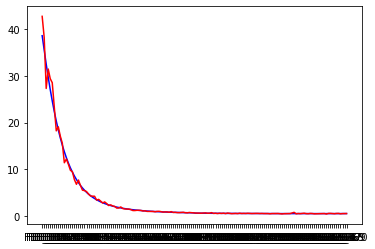

In [70]:
plt.figure()

plt.plot(qoi_test_copy.loc[index][F11_list],'b')
plt.plot(qoi_pred_fw_copy.loc[index][F11_list],'r')
#plt.yscale('log')

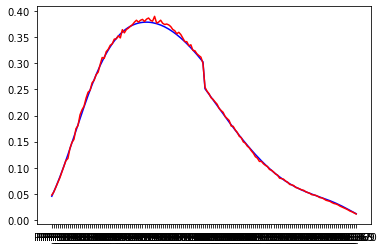

In [71]:
plt.figure()

plt.plot(qoi_test_copy.loc[index][PPF_list],'b')
plt.plot(qoi_pred_fw_copy.loc[index][PPF_list],'r')

In [34]:
'''def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n'''

def lognormal(D_array, D_median, GSD, Ntot):  # dn/dlogD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log10(GSD)))) * np.exp(-(np.log10(D_array)-np.log10(D_median))**2/(2*(np.log10(GSD)**2)))   # cm-3
    return n

def lognormal_fit(PSD, diameters, init_guess, fit_bounds):
    #fit_bounds=([0,0,2,0,0,3],[np.inf,1.25,5,np.inf,1.25,10])
    pu, pcovu = curve_fit(lognormal, diameters, PSD, p0=init_guess, bounds=fit_bounds, max_nfev=1e4)
    return(pu, pcovu)

def interp(df, new_index):
    """Return a new DataFrame with all columns values interpolated
    to the new_index values."""
    df_out = pd.DataFrame(index=new_index)
    df_out.index.name = df.index.name

    for colname, col in df.iteritems():
        df_out[colname] = np.interp(new_index, df.index, col)

    return df_out

def read_results(qoi, var='F11'):
    F11 = [x for x in qoi.index if var in x]
    index_list = [int(x[10:]) for x in F11]
    values = qoi[F11].values
    output = pd.DataFrame(index=index_list, columns=[var])
    output[var] = values
    return output

def run_pymiescatt(R_median, GSD, N_tot, ri_n, ri_k, wvl, angles, D_array):
    '''
    R_median in um (NOTE: this is the median radius of the NUMBER size distribution!)
    N_tot in cm-3
    ri_k as positive float number
    wvl in um
    angles is the array of angles
    D_array is the diameter array in nm
    '''
    lambd = wvl *1e3   # from um to nm
    m = ri_n + 1j * ri_k
    mu = np.cos(angles * np.pi / 180)
    
    n = lognormal(D_array, R_median*2 * 1e3, GSD, N_tot)/D_array / 2.303
    
    cscat = []
    for d in D_array:
            cscat_temp = pms.MieQ(m, lambd, d, asCrossSection=True)[1]
            cscat.append(cscat_temp)
    
    S11 = []
    S11_test = []
    S12 = []
    for diam in D_array:
        x = diam * np.pi / lambd
        theta, SL, SR, S11_temp = pms.ScatteringFunction(m, lambd, diam,
                                                        minAngle=angles.min(), maxAngle=angles.max(),
                                                        angularResolution=angles[1]-angles[0],
                                                        normalization=None)
        S11_test.append(S11_temp)
        # S11.append(S11_temp / np.trapz(S11_temp, x=np.flip(mu)) / (2*np.pi))
        qscat_temp = pms.MieQ(m, lambd, diam, asCrossSection=False)[1]
        S11.append(S11_temp / (qscat_temp * x**2 * np.pi))
        
        # S12.append( (0.5*(SR-SL)) / np.trapz(S11_temp, x=np.flip(mu)) / (2*np.pi))
        S12.append( (0.5*(SR-SL)) / (qscat_temp * x**2 * np.pi))
    S11 = np.array(S11).T
    # S11_test = np.array(S11_test).T
    S12 = np.array(S12).T            
         
    F11 = np.trapz(S11 * n * cscat * 1e-6, x=D_array)
    # F11_test = np.trapz(S11_test * n * (lambd / 4 / np.pi)**2 * 1e-6, x=D_array)
    F12 = np.trapz(S12 * n * cscat * 1e-6, x=D_array)
    PPF = - F12 / F11 
    
    pymiescatt = pd.DataFrame(index=angles, columns=['F11', 'F12', 'PPF'])
    pymiescatt['F11'] = F11
    # pymiescatt['F11_test'] = F11_test
    pymiescatt['F12'] = F12
    pymiescatt['PPF'] = PPF
    
    return pymiescatt

In [88]:
datafile= '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024.h5'



In [89]:

qoi_test1 = pd.read_hdf(datafile,'qoi')
dvar_test1 = pd.read_hdf(datafile,'param')

In [92]:
qoi_test1.values

array([[10.2929882684697, 10.202447435263515, 10.157936309129038, ...,
        0.036426750187639925, 0.03791238586144177, 0.04036518414743269],
       [319.7133256996953, 311.6800395602552, 305.24626906009354, ...,
        -0.23705650139644815, -0.1907126701467601, -0.15576477809923162],
       [171.62866868228986, 169.02540625607097, 158.07335665656876, ...,
        -0.3957540234667769, -0.31242607394188404, -0.24154764384811367],
       ...,
       [188.02391122815132, 182.20955990051007, 177.1590195228923, ...,
        0.03409970534502332, 0.06744949641185763, 0.09441832916324328],
       [356.24880905611775, 348.30550306993115, 337.11113946603655, ...,
        0.07691295239974077, 0.09388090096903848, 0.10401093050928854],
       [97.69832220829372, 91.91116504346559, 114.35496364473816, ...,
        0.0709627458755558, 0.08620266894569573, 0.06162048144571486]],
      dtype=object)

In [94]:
dvar_test1.values

array([[0.8435772785944015, 0.10046254575766635, 1.04, 1.59, 0.0001],
       [3.096041123438599, 0.25179175031380446, 1.05, 1.59, 0.0001],
       [1.3717843746927942, 0.30215010037656537, 1.05, 1.59, 0.0001],
       [3.5226067893345845, 0.4028668005020871, 1.05, 1.59, 0.0001],
       [4.763140189905537, 0.5035835006276089, 1.05, 1.59, 0.0001],
       [2.220049508409133, 0.07668973754792695, 1.09, 1.62, 0.223],
       [2.081532495301375, 0.11759093090682131, 1.09, 1.62, 0.223],
       [2.1488177039463574, 0.1526891720344757, 1.08, 1.62, 0.223],
       [3.873356837218622, 0.17813736737355498, 1.08, 1.62, 0.223],
       [2.4636272452475576, 0.19262728390269457, 1.07, 1.62, 0.223],
       [3.773135140628784, 0.2290337580517136, 1.08, 1.62, 0.223],
       [2.6463797772965805, 0.2646612315264246, 1.08, 1.62, 0.223],
       [4.618050362865892, 0.3041483430042546, 1.07, 1.62, 0.223],
       [2.0024846164372483, 0.394447027755729, 1.08, 1.62, 0.223]],
      dtype=object)

In [98]:
for i in range(14):
    dvar_test1.loc[i]=pd.to_numeric(dvar_test1.loc[i])
    qoi_test1.loc[i]=pd.to_numeric(qoi_test1.loc[i])

In [99]:
qoi_test1.values

array([[10.2929882684697, 10.202447435263515, 10.157936309129038, ...,
        0.036426750187639925, 0.03791238586144177, 0.04036518414743269],
       [319.7133256996953, 311.6800395602552, 305.24626906009354, ...,
        -0.23705650139644815, -0.1907126701467601, -0.15576477809923162],
       [171.62866868228986, 169.02540625607097, 158.07335665656876, ...,
        -0.3957540234667769, -0.31242607394188404, -0.24154764384811367],
       ...,
       [188.02391122815132, 182.20955990051007, 177.1590195228923, ...,
        0.03409970534502332, 0.06744949641185763, 0.09441832916324328],
       [356.24880905611775, 348.30550306993115, 337.11113946603655, ...,
        0.07691295239974077, 0.09388090096903848, 0.10401093050928854],
       [97.69832220829372, 91.91116504346559, 114.35496364473816, ...,
        0.0709627458755558, 0.08620266894569573, 0.06162048144571486]],
      dtype=object)

In [100]:
qoi_test1_2predict= qoi_test1.copy()

In [101]:
qoi_t1_2predict= pd.DataFrame(columns = qoi_test1_2predict.columns)
for i in range(14):
    desd1 = pd.to_numeric(qoi_test1_2predict.loc[i])
    qoi_t1_2predict.loc[i]=desd1

In [102]:
qoi_t1_2predict.values

array([[ 1.02929883e+01,  1.02024474e+01,  1.01579363e+01, ...,
         3.64267502e-02,  3.79123859e-02,  4.03651841e-02],
       [ 3.19713326e+02,  3.11680040e+02,  3.05246269e+02, ...,
        -2.37056501e-01, -1.90712670e-01, -1.55764778e-01],
       [ 1.71628669e+02,  1.69025406e+02,  1.58073357e+02, ...,
        -3.95754023e-01, -3.12426074e-01, -2.41547644e-01],
       ...,
       [ 1.88023911e+02,  1.82209560e+02,  1.77159020e+02, ...,
         3.40997053e-02,  6.74494964e-02,  9.44183292e-02],
       [ 3.56248809e+02,  3.48305503e+02,  3.37111139e+02, ...,
         7.69129524e-02,  9.38809010e-02,  1.04010931e-01],
       [ 9.76983222e+01,  9.19111650e+01,  1.14354964e+02, ...,
         7.09627459e-02,  8.62026689e-02,  6.16204814e-02]])

In [103]:
dvar_test1_2predict =dvar_test1.copy()
dvar_t1_2predict= pd.DataFrame(columns = dvar_test1_2predict.columns)
for i in range(14):
    desd1 = pd.to_numeric(dvar_test1_2predict.loc[i])
    dvar_t1_2predict.loc[i]=desd1

In [106]:
dvar_test1

Vtot  RmedianV   GSD     n       k
0   0.843577  0.100463  1.04  1.59  0.0001
1   3.096041  0.251792  1.05  1.59  0.0001
2   1.371784   0.30215  1.05  1.59  0.0001
3   3.522607  0.402867  1.05  1.59  0.0001
4    4.76314  0.503584  1.05  1.59  0.0001
5    2.22005   0.07669  1.09  1.62   0.223
6   2.081532  0.117591  1.09  1.62   0.223
7   2.148818  0.152689  1.08  1.62   0.223
8   3.873357  0.178137  1.08  1.62   0.223
9   2.463627  0.192627  1.07  1.62   0.223
10  3.773135  0.229034  1.08  1.62   0.223
11   2.64638  0.264661  1.08  1.62   0.223
12   4.61805  0.304148  1.07  1.62   0.223
13  2.002485  0.394447  1.08  1.62   0.223

In [105]:
dvar_t1_2predict

Vtot  RmedianV   GSD     n       k
0   0.843577  0.100463  1.04  1.59  0.0001
1   3.096041  0.251792  1.05  1.59  0.0001
2   1.371784  0.302150  1.05  1.59  0.0001
3   3.522607  0.402867  1.05  1.59  0.0001
4   4.763140  0.503584  1.05  1.59  0.0001
5   2.220050  0.076690  1.09  1.62  0.2230
6   2.081532  0.117591  1.09  1.62  0.2230
7   2.148818  0.152689  1.08  1.62  0.2230
8   3.873357  0.178137  1.08  1.62  0.2230
9   2.463627  0.192627  1.07  1.62  0.2230
10  3.773135  0.229034  1.08  1.62  0.2230
11  2.646380  0.264661  1.08  1.62  0.2230
12  4.618050  0.304148  1.07  1.62  0.2230
13  2.002485  0.394447  1.08  1.62  0.2230

In [107]:
dvar_t1_2predict.to_hdf('/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_values.h5', key = 'dvar')
qoi_t1_2predict.to_hdf('/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_values.h5', key = 'qoi')



In [ ]:
datafile= '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_values.h5'

dvar_test1 = pd.read_hdf(datafile,'dvar')
qoi_test1 = pd.read_hdf(datafile,'qoi')

In [115]:
dvar_test1

Vtot  RmedianV   GSD     n       k
0   0.843577  0.100463  1.04  1.59  0.0001
1   3.096041  0.251792  1.05  1.59  0.0001
2   1.371784  0.302150  1.05  1.59  0.0001
3   3.522607  0.402867  1.05  1.59  0.0001
4   4.763140  0.503584  1.05  1.59  0.0001
5   2.220050  0.076690  1.09  1.62  0.2230
6   2.081532  0.117591  1.09  1.62  0.2230
7   2.148818  0.152689  1.08  1.62  0.2230
8   3.873357  0.178137  1.08  1.62  0.2230
9   2.463627  0.192627  1.07  1.62  0.2230
10  3.773135  0.229034  1.08  1.62  0.2230
11  2.646380  0.264661  1.08  1.62  0.2230
12  4.618050  0.304148  1.07  1.62  0.2230
13  2.002485  0.394447  1.08  1.62  0.2230

In [116]:
F11_list_test = [x for x in qoi_test1.columns if 'F11' in x]
PPF_list_test = [x for x in qoi_test1.columns if 'PPF' in x]

In [117]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
angles = np.concatenate([angles1, angles2])
angles


array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170])

In [44]:
#colsum = (qoi_t1_2predict[F11_list_test]*angles).sum(axis = 1)


#qoi_t1_2predict[F11_list_test] = np.log(qoi_t1_2predict[F11_list_test]).divide(colsum, axis = 0)


In [118]:
qoi_t1_2predict[F11_list_test]=np.log(qoi_t1_2predict[F11_list_test]/4/np.pi)
qoi_t1_2predict[PPF_list_test]=(qoi_t1_2predict[PPF_list_test])

In [119]:
qoi_t1_2predict

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.199561     -0.208397     -0.212769     -0.221579     -0.234253   
1       3.236400      3.210953      3.190095      3.176939      3.142313   
2       2.614309      2.599025      2.532035      2.501506      2.535926   
3       3.012159      3.042673      2.985023      2.721631      2.733629   
4       2.602780      2.517139      2.344692      2.260295      2.197533   
5      -0.078021     -0.086697     -0.089969     -0.092307     -0.103138   
6       0.909239      0.896267      0.894234      0.889193      0.879337   
7       1.706418      1.700815      1.693317      1.691437      1.682543   
8       2.480806      2.476104      2.466042      2.455219      2.440502   
9       2.285199      2.280999      2.267148      2.266079      2.251123   
10      2.953820      2.940282      2.928117      2.916315      2.901677   
11      2.705545      2.674133      2.646023      2.616575      2.582985   
12      3.344605      3.322056      3.289388      3.252338      3.225176   
13      2.050860      1.989798      2.208283      2.193497      2.092762   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.235109     -0.238511     -0.246926     -0.250181     -0.257187  ...   
1       3.098304      3.084847      3.079266      3.058560      3.015682  ...   
2       2.528479      2.459868      2.360886      2.213174      2.163184  ...   
3       2.731514      2.528046      2.344214      2.093175      1.752889  ...   
4       2.012000      1.744945      1.527114      1.370812      1.182601  ...   
5      -0.106837     -0.104405     -0.114490     -0.119551     -0.120348  ...   
6       0.868961      0.861646      0.855756      0.845514      0.832707  ...   
7       1.665529      1.647456      1.628904      1.612665      1.597579  ...   
8       2.423184      2.406314      2.388203      2.377156      2.365967  ...   
9       2.228715      2.210645      2.194110      2.171250      2.145426  ...   
10      2.867769      2.833496      2.811605      2.797327      2.768091  ...   
11      2.557651      2.534402      2.504505      2.456602      2.404585  ...   
12      3.172034      3.146335      3.119594      3.031304      2.951275  ...   
13      2.025248      2.013026      1.976347      1.868395      1.688473  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.062705       0.058236       0.053258       0.041816       0.041821   
1       -0.442089      -0.402139      -0.369479      -0.335306      -0.310288   
2       -0.739106      -0.691336      -0.679427      -0.630740      -0.600472   
3       -0.575264      -0.536323      -0.507552      -0.553375      -0.525443   
4       -0.522459      -0.503661      -0.471962      -0.416038      -0.316883   
5        0.081435       0.078506       0.070624       0.065684       0.061138   
6        0.143271       0.121091       0.095935       0.084857       0.076034   
7       -0.085548      -0.104193      -0.112898      -0.077543      -0.072952   
8        0.021192       0.023545       0.023041       0.017631       0.031869   
9        0.239359       0.201787       0.167051       0.162393       0.164037   
10      -0.092794      -0.076136      -0.073104      -0.087072      -0.075848   
11       0.006520       0.018406       0.006810      -0.032775      -0.008622   
12       0.129906       0.116541       0.098241       0.084517       0.102488   
13       0.047823      -0.017431      -0.018607       0.080858      -0.055929   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.047582       0.038348       0.036427       0.037912       0.040365  
1       -0.296504      -0.274272      -0.237057      -0.190713      -0.155765  
2       -0.533391      -0.463790      -0.395754      -0.312426      -0.241548  
3       -0.337376      -0.288274      -0.286020      -0.250328      -0.227706  
4       -0.171938      -0.12752

In [182]:
dvar_t1_2predict = surr.sample_n_tries(qoi_t1_2predict.values,batch_size = 8, n_tries = 32)
dvar_t1_2predict

array([[-0.78326189,  4.50660106, -2.94935326, -1.2527262 , -0.75768394],
       [ 0.7626749 ,  5.71133399, -6.03527459, -0.39812908, -5.56303057],
       [-0.52608151,  6.02177829, -5.01903724,  0.39406186, -7.16732145],
       [ 2.03123201,  6.53790585, -3.37346382, -2.04809937, -3.52405929],
       [ 2.92606062,  8.09010772, -2.87724174, -0.9987435 , -4.83846447],
       [-0.95111449,  4.3476024 , -3.48480043, -1.94560872, -0.06105925],
       [-0.16444119,  4.71160517, -3.06027924, -1.2789508 , -0.95627378],
       [ 0.15615266,  5.3214707 , -3.23181268, -1.40986238, -2.51124842],
       [ 1.29244781,  5.18977863, -2.98482075, -1.1026481 , -1.99895476],
       [ 0.99097805,  5.43920965, -1.64107028, -1.00743264, -1.20360018],
       [ 1.29058087,  5.75736889, -3.52714594, -1.60701958, -0.28425818],
       [ 1.16795991,  5.6128855 , -3.15681951, -0.99319189, -1.01989264],
       [ 1.9594876 ,  6.04379977, -1.87358141, -1.00762235, -1.62260774],
       [ 1.68990903,  5.95581952, -4.0

In [180]:
dvar_t1_2predict = surr.sample_n_tries(qoi_t1_2predict.values,batch_size = 8, n_tries = 1)
dvar_t1_2predict

array([[-0.77831502,  4.494875  , -2.921932  , -1.29971403, -0.77264138],
       [ 0.76364963,  5.71201336, -6.03352367, -0.39660676, -5.55863264],
       [-0.52288548,  6.01980289, -5.0096559 ,  0.4004125 , -7.15285091],
       [ 2.03321757,  6.53918262, -3.36525166, -2.05132016, -3.51299411],
       [ 2.91834562,  8.09735543, -2.85118881, -1.1023233 , -4.76967582],
       [-0.95028591,  4.34392947, -3.48106935, -1.94129153, -0.03344652],
       [-0.17210888,  4.71101921, -3.08268681, -1.27783761, -0.94212684],
       [ 0.12597388,  5.32395222, -3.26409391, -1.39469357, -2.56867091],
       [ 1.29780877,  5.19083262, -2.98215304, -1.1054508 , -2.00014253],
       [ 0.98968363,  5.4343734 , -1.64335735, -1.00259218, -1.21265128],
       [ 1.28478512,  5.75389757, -3.51215138, -1.60678645, -0.27139608],
       [ 1.16726218,  5.612884  , -3.15858492, -0.99626998, -1.01754634],
       [ 1.97030938,  6.04183472, -1.85827368, -1.03720085, -1.59928185],
       [ 1.70774914,  5.93512047, -4.0

In [121]:
dvar_test

Vtot  RmedianV       GSD         n         k
0      2.280593  6.607941 -0.150092 -1.717834  0.455426
1      1.600002  6.102782 -0.374906  0.256803 -0.282094
2      2.287829  7.990614  0.491880 -0.277107  0.580761
3      3.321433  5.539645 -3.120120  0.459762  0.096398
4      3.892055  6.252764  0.170222  0.033481  0.720606
...         ...       ...       ...       ...       ...
19995  7.973462  5.500517  0.047604 -2.047781 -0.757798
19996  1.333215  5.319826 -1.577609 -1.460957  0.078665
19997  2.196189  6.269244 -0.051620  0.307078  0.628067
19998  7.769406  6.659412  0.441988  0.389882 -0.619758
19999  4.435587  5.127723  0.457345  0.209728  0.099018

[20000 rows x 5 columns]

In [122]:
dvar_t1_2predict = pd.DataFrame(data = dvar_t1_2predict, columns = dvar_test1.columns)

In [123]:
dvar_t1_2predict_2qoi = dvar_t1_2predict.copy()

In [124]:
dvar_t1_2predict_2qoi

Vtot  RmedianV       GSD         n         k
0  -0.766592  4.505705 -2.940117 -1.294237 -0.764478
1   0.766749  5.713018 -6.039825 -0.388102 -5.553343
2  -0.526316  6.021483 -5.015663  0.397201 -7.166480
3   2.031721  6.540227 -3.364997 -2.046673 -3.515698
4   2.920006  8.094224 -2.862056 -1.061177 -4.806403
5  -0.948251  4.341931 -3.488948 -1.939877 -0.014164
6  -0.169629  4.711101 -3.102330 -1.300442 -0.911150
7   0.156206  5.320212 -3.231359 -1.402290 -2.511044
8   1.303749  5.191682 -2.984437 -1.108233 -2.004532
9   1.001389  5.435069 -1.650494 -1.002403 -1.191980
10  1.285907  5.759850 -3.522175 -1.597678 -0.253584
11  1.167908  5.612911 -3.156716 -0.994305 -1.020261
12  1.944976  6.039410 -1.872866 -1.026068 -1.598519
13  1.683505  5.914228 -4.123096 -2.289533 -1.903988

In [125]:
#dvar_t1_2predict['k'] = dvar_t1_2predict['k']-10

In [126]:
dvar_t1_2predict['Vtot']=np.exp(dvar_t1_2predict['Vtot'])
dvar_t1_2predict['RmedianV']=np.exp(dvar_t1_2predict['RmedianV'])
dvar_t1_2predict['GSD']=np.exp(dvar_t1_2predict['GSD'])+1
dvar_t1_2predict['n']=np.exp(dvar_t1_2predict['n'])+1.33
dvar_t1_2predict['k']=np.exp(dvar_t1_2predict['k'])

In [127]:
dvar_t1_2predict['RmedianV']=dvar_t1_2predict['RmedianV']*1e-3

In [128]:
dvar_t1_2predict

Vtot  RmedianV       GSD         n         k
0    0.464594  0.090532  1.052860  1.604107  0.465577
1    2.152756  0.302784  1.002382  2.008343  0.003874
2    0.590777  0.412189  1.006633  2.817655  0.000772
3    7.627205  0.692444  1.034562  1.459164  0.029727
4   18.541398  3.275494  1.057151  1.676048  0.008177
5    0.387418  0.076856  1.030533  1.473722  0.985936
6    0.843978  0.111175  1.044944  1.602411  0.402062
7    1.169067  0.204427  1.039504  1.576033  0.081183
8    3.683080  0.179771  1.050568  1.660142  0.134723
9    2.722061  0.229309  1.191955  1.696996  0.303620
10   3.617947  0.317301  1.029535  1.532366  0.776014
11   3.215259  0.273941  1.042565  1.699980  0.360501
12   6.993465  0.419646  1.153683  1.688413  0.202196
13   5.384396  0.370268  1.016194  1.431314  0.148973

In [129]:
dvar_test1

Vtot  RmedianV   GSD     n       k
0   0.843577  0.100463  1.04  1.59  0.0001
1   3.096041  0.251792  1.05  1.59  0.0001
2   1.371784  0.302150  1.05  1.59  0.0001
3   3.522607  0.402867  1.05  1.59  0.0001
4   4.763140  0.503584  1.05  1.59  0.0001
5   2.220050  0.076690  1.09  1.62  0.2230
6   2.081532  0.117591  1.09  1.62  0.2230
7   2.148818  0.152689  1.08  1.62  0.2230
8   3.873357  0.178137  1.08  1.62  0.2230
9   2.463627  0.192627  1.07  1.62  0.2230
10  3.773135  0.229034  1.08  1.62  0.2230
11  2.646380  0.264661  1.08  1.62  0.2230
12  4.618050  0.304148  1.07  1.62  0.2230
13  2.002485  0.394447  1.08  1.62  0.2230

In [130]:
qoi_t1_2predict_pred = surr.predict(dvar_t1_2predict_2qoi.values)

In [131]:
qoi_t1_2predict_pred

array([[ 0.12171439, -0.10128721,  0.07131052, ...,  0.026567  ,
         0.02597729,  0.01889701],
       [ 1.38723658,  3.73476353,  2.32832344, ...,  0.19057012,
         0.16626205,  0.15231044],
       [-1.57006529,  1.83747133,  0.13664735, ...,  0.26401818,
         0.24663592,  0.21994083],
       ...,
       [ 3.39810481,  3.11019833,  2.5873674 , ...,  0.07803536,
         0.06607891,  0.0512623 ],
       [ 3.7728643 ,  4.52672029,  3.62295561, ...,  0.0818575 ,
         0.07303255,  0.06329051],
       [ 3.97498374,  4.53391499,  3.63233017, ..., -0.0381447 ,
        -0.03678413, -0.03389967]])

In [132]:
qoi_t1_2predict_pred = pd.DataFrame(data=qoi_t1_2predict_pred, columns=qoi_columns)
qoi_t1_2predict_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   0.121714 -0.101287  0.071311 -0.178733 -0.492829 -0.913765 -0.725683   
1   1.387237  3.734764  2.328323  3.561682  1.968885  1.745003  2.669687   
2  -1.570065  1.837471  0.136647  0.767489  0.655622 -1.375756 -0.176487   
3   2.657983  4.174352  3.133106  3.162821  2.047514  1.025823  3.059521   
4   1.883936  2.346842  1.848978  0.552305 -0.198203 -0.148672  1.065047   
5  -0.499627 -0.130266 -0.131783 -0.174191 -0.266211 -1.129039 -0.896135   
6   0.614555  0.330291  0.752693  0.067009 -0.058756 -0.234423 -0.102780   
7   2.414114  1.702409  1.786891  1.727368  2.553752  2.331931  1.580952   
8   2.888023  2.439282  2.428476  2.346622  2.978684  2.829616  3.368477   
9   2.619808  2.350297  2.149712  2.508341  2.303078  2.853831  2.204663   
10  3.936198  3.197486  2.672289  2.729592  2.682206  3.009040  2.875209   
11  3.398105  3.110198  2.587367  3.858533  2.755103  5.176703  2.604460   
12  3.772864  4.526720  3.622956  3.475264  3.296442  3.129375  3.409668   
13  3.974984  4.533915  3.632330  3.715992  4.283423  3.255162  3.224672   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0   0.994445  0.294519  0.608625  ...  0.072301  0.064081  0.057509  0.047950   
1   0.188914  5.274159  2.362725  ...  0.440615  0.416105  0.406316  0.395043   
2  -2.977589  4.196312  0.931685  ...  0.525622  0.531239  0.525810  0.519821   
3   0.189146  1.016867  1.120747  ... -0.035877 -0.106734 -0.153548 -0.219821   
4  -0.232788  2.414950  0.777319  ...  0.088608  0.139331  0.203194  0.234402   
5   1.036762  0.251321  0.755522  ...  0.064078  0.056755  0.051553  0.041487   
6   1.058604  0.666621  0.897892  ...  0.079968  0.068817  0.061810  0.052757   
7   0.317393  1.776375  1.703416  ...  0.010726 -0.000837 -0.001934 -0.003737   
8   1.448026  3.162816  2.546571  ...  0.064162  0.051351  0.056644  0.050868   
9   1.769745  2.085550  2.058105  ...  0.084358  0.078638  0.074464  0.069629   
10  3.923083  2.972595  2.430674  ...  0.013278  0.013019  0.011772  0.011805   
11  3.369853  2.136987  2.408100  ...  0.135802  0.123338  0.115857  0.107390   
12  2.740252  2.663460  2.581889  ...  0.047319  0.057947  0.071904  0.077684   
13  3.256494  3.898940  2.612603  ... -0.099397 -0.091269 -0.076409 -0.071601   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.043633  0.038396  0.033620  0.026567  0.025977  0.018897  
1   0.347989  0.294843  0.254734  0.190570  0.166262  0.152310  
2   0.464935  0.396437  0.359536  0.264018  0.246636  0.219941  
3  -0.281170 -0.340612 -0.405771 -0.435452 -0.459656 -0.449486  
4   0.277112  0.298898  0.303178  0.298737  0.306594  0.310013  
5   0.038013  0.033355  0.031157  0.021571  0.022966  0.016522  
6   0.047515  0.041006  0.032594  0.030080  0.025712  0.019988  
7  -0.013566 -0.009076 -0.007758  0.006940  0.001148 -0.001384  
8   0.046182  0.042796  0.037945  0.044515  0.034971  0.029431  
9   0.064798  0.058621  0.055161  0.050483  0.043871  0.036457  
10  0.012999  0.011329  0.010083  0.010336  0.009618  0.009410  
11  0.103091  0.098198  0.090975  0.078035  0.066079  0.051262  
12  0.085677  0.091691  0.089219  0.081857  0.073033  0.063291  
13 -0.063292 -0.048593 -0.046883 -0.038145 -0.036784 -0.033900  

[14 rows x 304 columns]

In [133]:
F11_list= [x for x in qoi_t1_2predict_pred.columns if 'F11' in x]
PPF_list= [x for x in qoi_t1_2predict_pred.columns if 'PPF' in x]

In [134]:
qoi_t1_2predict_pred[F11_list]=np.exp(qoi_t1_2predict_pred[F11_list])
#qoi_t1_2predict_pred[PPF_list]=(qoi_t1_2predict_pred[PPF_list])


In [135]:
qoi_t1_2predict_pred

F11_10     F11_11     F11_12     F11_13     F11_14      F11_15  \
0    1.129431   0.903673   1.073915   0.836329   0.610895    0.401012   
1    4.003771  41.878122  10.260724  35.222394   7.162683    5.725918   
2    0.208032   6.280637   1.146424   2.154351   1.926341    0.252649   
3   14.267488  64.997705  22.945132  23.637187   7.748615    2.789391   
4    6.579354  10.452508   6.353321   1.737252   0.820203    0.861852   
5    0.606757   0.877862   0.876531   0.840137   0.766277    0.323344   
6    1.848833   1.391373   2.122709   1.069305   0.942936    0.791028   
7   11.179863   5.487152   5.970863   5.625829  12.855246   10.297804   
8   17.957779  11.464804  11.341580  10.450212  19.661916   16.938963   
9   13.733089  10.488685   8.582390  12.284528  10.004929   17.354133   
10  51.223460  24.470942  14.473059  15.326628  14.617306   20.267943   
11  29.907366  22.425492  13.294726  47.395777  15.722656  177.097905   
12  43.504496  92.454838  37.448086  32.306363  27.016334   22.859681   
13  53.249251  93.122421  37.800797  41.099338  72.488167   25.923808   

       F11_16     F11_17      F11_18     F11_19  ...   PPF_161   PPF_162  \
0    0.483994   2.703224    1.342481   1.837902  ...  0.072301  0.064081   
1   14.435454   1.207937  195.226233  10.619854  ...  0.440615  0.416105   
2    0.838210   0.050915   66.440858   2.538783  ...  0.525622  0.531239   
3   21.317346   1.208218    2.764520   3.067146  ... -0.035877 -0.106734   
4    2.900976   0.792322   11.189211   2.175632  ...  0.088608  0.139331   
5    0.408144   2.820070    1.285723   2.128722  ...  0.064078  0.056755   
6    0.902325   2.882345    1.947645   2.454424  ...  0.079968  0.068817   
7    4.859580   1.373542    5.908397   5.492678  ...  0.010726 -0.000837   
8   29.034285   4.254709   23.637074  12.763260  ...  0.064162  0.051351   
9    9.067199   5.869356    8.049015   7.831118  ...  0.084358  0.078638   
10  17.729135  50.556068   19.542565  11.366542  ...  0.013278  0.013019   
11  13.523919  29.074242    8.473864  11.112825  ...  0.135802  0.123338   
12  30.255183  15.490884   14.345846  13.222086  ...  0.047319  0.057947   
13  25.145326  25.958365   49.350125  13.634489  ... -0.099397 -0.091269   

     PPF_163   PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169  \
0   0.057509  0.047950  0.043633  0.038396  0.033620  0.026567  0.025977   
1   0.406316  0.395043  0.347989  0.294843  0.254734  0.190570  0.166262   
2   0.525810  0.519821  0.464935  0.396437  0.359536  0.264018  0.246636   
3  -0.153548 -0.219821 -0.281170 -0.340612 -0.405771 -0.435452 -0.459656   
4   0.203194  0.234402  0.277112  0.298898  0.303178  0.298737  0.306594   
5   0.051553  0.041487  0.038013  0.033355  0.031157  0.021571  0.022966   
6   0.061810  0.052757  0.047515  0.041006  0.032594  0.030080  0.025712   
7  -0.001934 -0.003737 -0.013566 -0.009076 -0.007758  0.006940  0.001148   
8   0.056644  0.050868  0.046182  0.042796  0.037945  0.044515  0.034971   
9   0.074464  0.069629  0.064798  0.058621  0.055161  0.050483  0.043871   
10  0.011772  0.011805  0.012999  0.011329  0.010083  0.010336  0.009618   
11  0.115857  0.107390  0.103091  0.098198  0.090975  0.078035  0.066079   
12  0.071904  0.077684  0.085677  0.091691  0.089219  0.081857  0.073033   
13 -0.076409 -0.071601 -0.063292 -0.048593 -0.046883 -0.038145 -0.036784   

     PPF_170  
0   0.018897  
1   0.152310  
2   0.219941  
3  -0.449486  
4   0.310013  
5   0.016522  
6   0.019988  
7  -0.001384  
8   0.029431  
9   0.036457  
10  0.009410  
11  0.051262  
12  0.063291  
13 -0.033900  

[14 rows x 304 columns]

In [136]:
pymiescatt_df = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5',key='qoi')


In [137]:
index =6
D_array = np.logspace(0.1, 5, 300)  # [nm] base 10
theta = np.arange(0,181,1)

In [138]:
newcolumns = []
F11_newcolumns = []
PPF_newcolumns = []

for i in range(0,181):
    newcolumns.append('F11_'+str(i))
    F11_newcolumns.append('F11_'+str(i))
for j in range(0,181):
    newcolumns.append('PPF_'+str(j))
    PPF_newcolumns.append('PPF_'+str(j))
newcolumns

['F11_0',
 'F11_1',
 'F11_2',
 'F11_3',
 'F11_4',
 'F11_5',
 'F11_6',
 'F11_7',
 'F11_8',
 'F11_9',
 'F11_10',
 'F11_11',
 'F11_12',
 'F11_13',
 'F11_14',
 'F11_15',
 'F11_16',
 'F11_17',
 'F11_18',
 'F11_19',
 'F11_20',
 'F11_21',
 'F11_22',
 'F11_23',
 'F11_24',
 'F11_25',
 'F11_26',
 'F11_27',
 'F11_28',
 'F11_29',
 'F11_30',
 'F11_31',
 'F11_32',
 'F11_33',
 'F11_34',
 'F11_35',
 'F11_36',
 'F11_37',
 'F11_38',
 'F11_39',
 'F11_40',
 'F11_41',
 'F11_42',
 'F11_43',
 'F11_44',
 'F11_45',
 'F11_46',
 'F11_47',
 'F11_48',
 'F11_49',
 'F11_50',
 'F11_51',
 'F11_52',
 'F11_53',
 'F11_54',
 'F11_55',
 'F11_56',
 'F11_57',
 'F11_58',
 'F11_59',
 'F11_60',
 'F11_61',
 'F11_62',
 'F11_63',
 'F11_64',
 'F11_65',
 'F11_66',
 'F11_67',
 'F11_68',
 'F11_69',
 'F11_70',
 'F11_71',
 'F11_72',
 'F11_73',
 'F11_74',
 'F11_75',
 'F11_76',
 'F11_77',
 'F11_78',
 'F11_79',
 'F11_80',
 'F11_81',
 'F11_82',
 'F11_83',
 'F11_84',
 'F11_85',
 'F11_86',
 'F11_87',
 'F11_88',
 'F11_89',
 'F11_90',
 'F11_91'

In [139]:
theta_meas = []
for i in range(10,86):
    theta_meas.append(i)
for i in range(95,171):
    theta_meas.append(i)
theta_meas

[10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170]

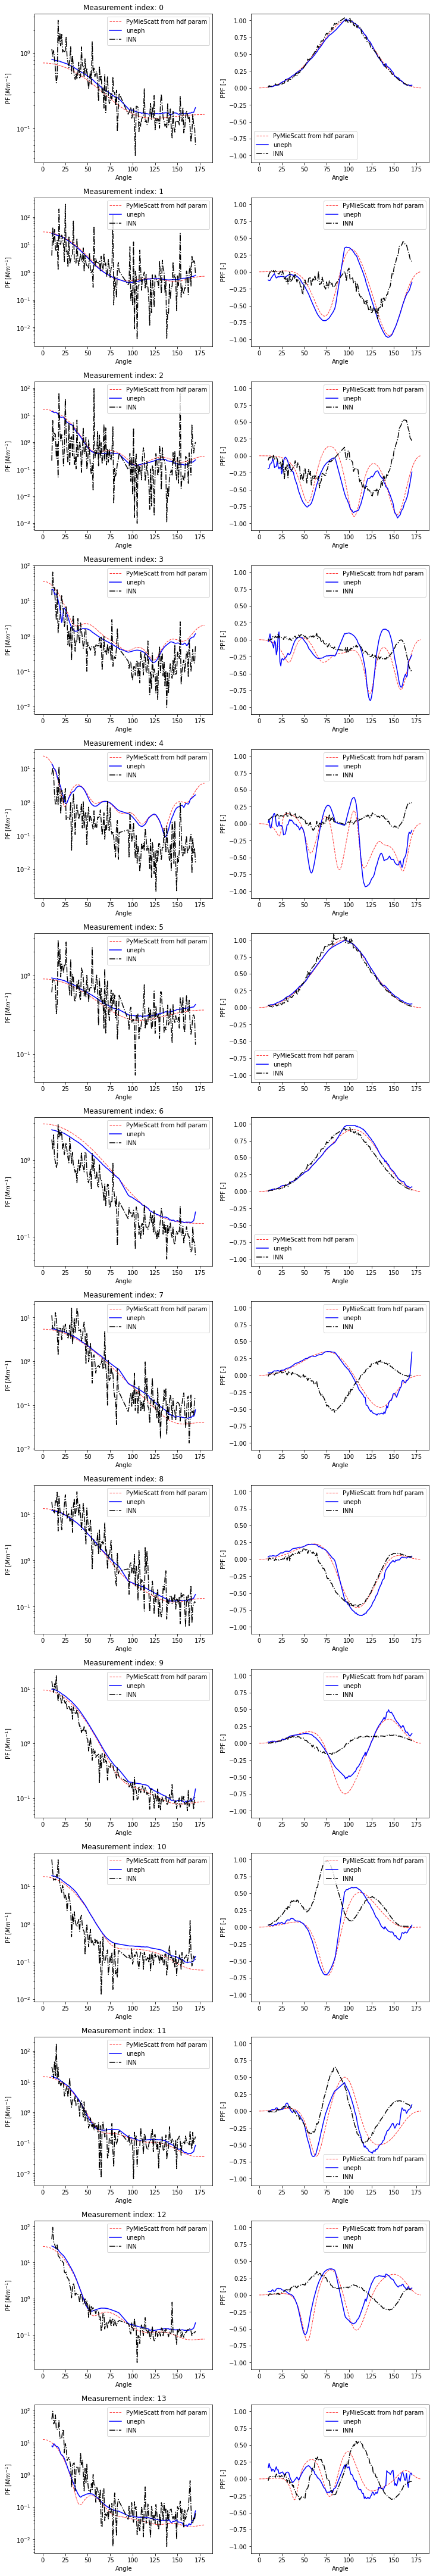

In [140]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)

for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[index,0].plot(theta, pymiescatt_df[F11_newcolumns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_hdf_plot, = axs[index,1].plot(theta, pymiescatt_df[PPF_newcolumns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_hdf_plot, = axs[index,0].plot(theta_meas, qoi_test1[F11_list_test].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_hdf_plot, = axs[index,1].plot(theta_meas, qoi_test1[PPF_list_test].loc[index].values, c= 'b', label = 'uneph')
    
    meas_hdf_pred, = axs[index,0].plot(theta_meas, qoi_t1_2predict_pred[F11_list].loc[index].values,ls='-.', c= 'k', label = 'INN')
    meas_hdf_pred, = axs[index,1].plot(theta_meas, qoi_t1_2predict_pred[PPF_list].loc[index].values,ls='-.', c= 'k', label = 'INN')

    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot,meas_hdf_pred])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/pymiescatt_measurements_pred.jpg')

In [160]:
abs_err_dvar = (dvar_test1 - dvar_t1_2predict).abs()
abs_err_dvar

Vtot  RmedianV       GSD         n         k
0    0.378984  0.009930  0.012860  0.014107  0.465477
1    0.943285  0.050992  0.047618  0.418343  0.003774
2    0.781007  0.110039  0.043367  1.227655  0.000672
3    4.104598  0.289577  0.015438  0.130836  0.029627
4   13.778258  2.771911  0.007151  0.086048  0.008077
5    1.832632  0.000166  0.059467  0.146278  0.762936
6    1.237555  0.006416  0.045056  0.017589  0.179062
7    0.979751  0.051738  0.040496  0.043967  0.141817
8    0.190277  0.001633  0.029432  0.040142  0.088277
9    0.258433  0.036681  0.121955  0.076996  0.080620
10   0.155188  0.088267  0.050465  0.087634  0.553014
11   0.568879  0.009279  0.037435  0.079980  0.137501
12   2.375414  0.115497  0.083683  0.068413  0.020804
13   3.381911  0.024179  0.063806  0.188686  0.074027

In [159]:
rel_err_dvar = abs_err_dvar/dvar_test1.abs()
rel_err_dvar

Vtot  RmedianV       GSD         n            k
0   0.449258  0.098847  0.012365  0.008872  4654.770623
1   0.304675  0.202516  0.045350  0.263109    37.744832
2   0.569337  0.364188  0.041302  0.772110     6.720357
3   1.165216  0.718792  0.014703  0.082287   296.270564
4   2.892684  5.504372  0.006811  0.054118    80.772204
5   0.825491  0.002165  0.054557  0.090295     3.421235
6   0.594540  0.054565  0.041335  0.010857     0.802967
7   0.455949  0.338846  0.037497  0.027140     0.635949
8   0.049125  0.009169  0.027252  0.024779     0.395860
9   0.104900  0.190427  0.113977  0.047529     0.361523
10  0.041130  0.385388  0.046727  0.054095     2.479885
11  0.214965  0.035061  0.034662  0.049371     0.616596
12  0.514376  0.379740  0.078208  0.042230     0.093293
13  1.688858  0.061297  0.059079  0.116473     0.331958

In [147]:
qoi_test1[F11_list_test]

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      10.292988     10.202447     10.157936     10.068842      9.942028   
1     319.713326    311.680040    305.246269    301.256849    291.003992   
2     171.628669    169.025406    158.073357    153.320459    158.689681   
3     255.490087    263.406212    248.650204    191.072936    193.379311   
4     169.661308    155.736160    131.068012    120.460237    113.132208   
5      11.623200     11.522790     11.485159     11.458338     11.334892   
6      31.195179     30.793104     30.730566     30.576065     30.276192   
7      69.230554     68.843726     68.329483     68.201156     67.597278   
8     150.179422    149.474910    147.978382    146.385494    144.246849   
9     123.497759    122.980150    121.288541    121.158893    119.360380   
10    241.011311    237.770535    234.895710    232.139757    228.766429   
11    188.023911    182.209560    177.159020    172.017967    166.335981   
12    356.248809    348.305503    337.111139    324.849469    316.144836   
13     97.698322     91.911165    114.354964    112.676577    101.879081   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0       9.933527      9.899784      9.816825      9.784930      9.716613  ...   
1     278.475044    274.752536    273.223423    267.624397    256.391614  ...   
2     157.512209    147.067530    133.207793    114.915648    109.312189  ...   
3     192.970691    157.444078    131.005377    101.921150     72.523689  ...   
4      93.974540     71.949823     57.866504     49.493270     41.002167  ...   
5      11.293051     11.320542     11.206947     11.150377     11.141497  ...   
6      29.963659     29.745276     29.570581     29.269259     28.896808  ...   
7      66.456888     65.266585     64.066910     63.034934     62.091119  ...   
8     141.770377    139.398776    136.896733    135.392823    133.886400  ...   
9     116.715543    114.625422    112.745620    110.197502    107.388154  ...   
10    221.139446    213.688628    209.061573    206.097833    200.159731  ...   
11    162.174808    158.447923    153.780910    146.588038    139.157964  ...   
12    299.782826    292.176839    284.467388    260.428515    240.398889  ...   
13     95.227836     94.071005     90.683122     81.403601     67.999321  ...   

    F11_0.532_161  F11_0.532_162  F11_0.532_163  F11_0.532_164  F11_0.532_165  \
0        1.958931       1.962807       1.992564       1.993857       2.009956   
1        8.043411       8.153828       8.257236       8.448753       8.568876   
2        1.874435       2.006722       2.095341       2.231123       2.371653   
3        6.797895       7.689778       8.379640      10.542381      10.744919   
4       10.938459      10.819327      11.951784      14.493855      15.863120   
5        4.802068       4.826657       4.863002       4.874745       4.881570   
6        1.942945       1.947679       1.942986       1.946821       1.917769   
7        0.622455       0.628048       0.649783       0.646252       0.638612   
8        1.694099       1.711694       1.754213       1.802210       1.818885   
9        1.055106       1.072119       1.104037       1.123538       1.103309   
10       1.176375       1.208126       1.221871       1.223165       1.212812   
11       0.545894       0.541612       0.560773       0.559447       0.551876   
12       1.664173       1.685728       1.703744       1.746772       1.754830   
13       0.314137       0.353982       0.382469       0.353136       0.363891   

    F11_0.532_166  F11_0.532_167  F11_0.532_168  F11_0.532_169  F11_0.532_170  
0        2.053279       2.041124       2.041251       2.210118       2.356196  
1        8.763116       8.859035       9.011610       9.366427       9.779722  
2        2.299251       2.286370       2.427359       2.583871       2.779124  
3       11.335842      11.515819      11.665061      13.141673      14.313969  
4       16.329939      17.12361

In [148]:
qoi_t1_2predict_pred[F11_list]

F11_10     F11_11     F11_12     F11_13     F11_14      F11_15  \
0    1.129431   0.903673   1.073915   0.836329   0.610895    0.401012   
1    4.003771  41.878122  10.260724  35.222394   7.162683    5.725918   
2    0.208032   6.280637   1.146424   2.154351   1.926341    0.252649   
3   14.267488  64.997705  22.945132  23.637187   7.748615    2.789391   
4    6.579354  10.452508   6.353321   1.737252   0.820203    0.861852   
5    0.606757   0.877862   0.876531   0.840137   0.766277    0.323344   
6    1.848833   1.391373   2.122709   1.069305   0.942936    0.791028   
7   11.179863   5.487152   5.970863   5.625829  12.855246   10.297804   
8   17.957779  11.464804  11.341580  10.450212  19.661916   16.938963   
9   13.733089  10.488685   8.582390  12.284528  10.004929   17.354133   
10  51.223460  24.470942  14.473059  15.326628  14.617306   20.267943   
11  29.907366  22.425492  13.294726  47.395777  15.722656  177.097905   
12  43.504496  92.454838  37.448086  32.306363  27.016334   22.859681   
13  53.249251  93.122421  37.800797  41.099338  72.488167   25.923808   

       F11_16     F11_17      F11_18     F11_19  ...   F11_161   F11_162  \
0    0.483994   2.703224    1.342481   1.837902  ...  0.154228  0.130728   
1   14.435454   1.207937  195.226233  10.619854  ...  0.783140  0.156933   
2    0.838210   0.050915   66.440858   2.538783  ...  0.239954  0.029851   
3   21.317346   1.208218    2.764520   3.067146  ...  0.366265  0.067001   
4    2.900976   0.792322   11.189211   2.175632  ...  0.029592  0.038577   
5    0.408144   2.820070    1.285723   2.128722  ...  0.369001  0.346686   
6    0.902325   2.882345    1.947645   2.454424  ...  0.116333  0.102061   
7    4.859580   1.373542    5.908397   5.492678  ...  0.146136  0.160218   
8   29.034285   4.254709   23.637074  12.763260  ...  0.125043  0.176153   
9    9.067199   5.869356    8.049015   7.831118  ...  0.058006  0.137760   
10  17.729135  50.556068   19.542565  11.366542  ...  0.101905  0.132200   
11  13.523919  29.074242    8.473864  11.112825  ...  0.098079  0.099482   
12  30.255183  15.490884   14.345846  13.222086  ...  0.139651  0.140047   
13  25.145326  25.958365   49.350125  13.634489  ...  0.077748  0.085196   

     F11_163   F11_164   F11_165   F11_166   F11_167   F11_168   F11_169  \
0   0.142939  0.102575  0.065743  0.086078  0.152639  0.111667  0.105376   
1   1.057038  1.732161  0.314626  3.793144  2.095903  2.629374  2.473371   
2   0.400151  0.117157  0.060805  4.291334  0.768201  0.398007  0.709806   
3   0.795942  0.215987  0.098036  0.186126  0.412533  0.174525  0.168204   
4   0.041389  0.081860  0.108471  0.007464  0.081539  0.030452  0.041645   
5   0.481775  0.243599  0.177722  0.210896  0.303194  0.313322  0.287703   
6   0.099817  0.073255  0.063639  0.067177  0.135755  0.085734  0.085736   
7   0.013574  0.044849  0.168354  0.066114  0.071496  0.055759  0.138084   
8   0.037528  0.154350  0.283326  0.043954  0.096878  0.115057  0.127752   
9   0.069688  0.082317  0.098164  0.081394  0.085595  0.062665  0.099264   
10  0.189422  1.228348  0.176586  0.076784  0.108503  0.140712  0.126418   
11  0.085186  0.246192  0.092185  0.061358  0.219637  0.095488  0.125107   
12  0.152331  0.143525  0.128635  0.095101  0.115439  0.115786  0.113484   
13  0.234703  0.658142  0.098587  0.030686  0.032343  0.048368  0.040828   

     F11_170  
0   0.060367  
1   0.890615  
2   0.999059  
3   0.549051  
4   0.015818  
5   0.130326  
6   0.055540  
7   0.146808  
8   0.121977  
9   0.106569  
10  0.111722  
11  0.158748  
12  0.128023  
13  0.064514  

[14 rows x 152 columns]

In [154]:
abs_error_qoi_F11 = np.abs(qoi_test1[F11_list_test].values-qoi_t1_2predict_pred[F11_list].values)
abs_error_qoi_F11 = pd.DataFrame(data = abs_error_qoi_F11,columns = qoi_t1_2predict_pred[F11_list].columns )
abs_error_qoi_F11.mean(axis = 1)

0      3.873859
1     48.086427
2     21.435534
3     21.734968
4     16.808840
5      5.541343
6     10.036779
7     16.153360
8     29.675217
9     23.007612
10    36.391722
11    21.300843
12    36.134547
13     6.151448
dtype: float64

In [153]:
abs_error_qoi_PPF = np.abs(qoi_test1[PPF_list_test].values-qoi_t1_2predict_pred[PPF_list].values)
abs_error_qoi_PPF = pd.DataFrame(data = abs_error_qoi_PPF,columns = qoi_t1_2predict_pred[PPF_list].columns )
abs_error_qoi_PPF.mean(axis = 1)

0     0.026620
1     0.361776
2     0.362740
3     0.233219
4     0.379964
5     0.041315
6     0.069869
7     0.357994
8     0.135987
9     0.163982
10    0.410020
11    0.180459
12    0.272572
13    0.239792
dtype: float64

In [157]:
rel_error_qoi_F11 = abs_error_qoi_F11.values/np.abs(qoi_test1[F11_list_test].values)
rel_error_qoi_F11 = pd.DataFrame(data =rel_error_qoi_F11, columns = qoi_t1_2predict_pred[F11_list].columns)
rel_error_qoi_F11.mean(axis = 1)



0     0.916312
1     0.985686
2     1.347487
3     0.945579
4     0.974835
5     0.913305
6     0.950133
7     0.900452
8     0.885120
9     0.936902
10    0.945705
11    0.905847
12    0.936190
13    0.805279
dtype: float64

In [158]:
rel_error_qoi_PPF = abs_error_qoi_PPF.values/np.abs(qoi_test1[PPF_list_test].values)
rel_error_qoi_PPF = pd.DataFrame(data =rel_error_qoi_PPF, columns = qoi_t1_2predict_pred[PPF_list].columns)
rel_error_qoi_PPF.mean(axis = 1)



0      0.107596
1      1.472455
2      0.881138
3      1.793924
4      2.335214
5      0.167424
6      0.206660
7      1.630495
8      2.791262
9      1.168718
10     4.165075
11     6.548342
12     1.920785
13    95.668262
dtype: float64

In [172]:
results_dataframe = pd.DataFrame(columns = ['AE_F11','AE_PPF','AE_Vtot','AE_RmedianV','AE_GSD','AE_n','AE_k','RE_F11','RE_PPF','RE_Vtot','RE_RmedianV','RE_GSD','RE_n','RE_k'])
results_dataframe['AE_F11'] =abs_error_qoi_F11.mean(axis = 1)
results_dataframe['RE_F11'] =rel_error_qoi_F11.mean(axis = 1)
results_dataframe['AE_PPF'] =abs_error_qoi_PPF.mean(axis = 1)
results_dataframe['RE_PPF'] =rel_error_qoi_PPF.mean(axis = 1)
results_dataframe['AE_Vtot'] =abs_err_dvar['Vtot']
results_dataframe['RE_Vtot'] =rel_err_dvar['Vtot']
results_dataframe['AE_RmedianV'] =abs_err_dvar['RmedianV']
results_dataframe['RE_RmedianV'] =rel_err_dvar['RmedianV']
results_dataframe['AE_GSD'] =abs_err_dvar['GSD']
results_dataframe['RE_GSD'] =rel_err_dvar['GSD']
results_dataframe['AE_n'] =abs_err_dvar['n']
results_dataframe['RE_n'] =rel_err_dvar['n']
results_dataframe['AE_k'] =abs_err_dvar['k']
results_dataframe['RE_k'] =rel_err_dvar['k']




In [173]:
results_dataframe

AE_F11    AE_PPF    AE_Vtot  AE_RmedianV    AE_GSD      AE_n      AE_k  \
0    3.873859  0.026620   0.378984     0.009930  0.012860  0.014107  0.465477   
1   48.086427  0.361776   0.943285     0.050992  0.047618  0.418343  0.003774   
2   21.435534  0.362740   0.781007     0.110039  0.043367  1.227655  0.000672   
3   21.734968  0.233219   4.104598     0.289577  0.015438  0.130836  0.029627   
4   16.808840  0.379964  13.778258     2.771911  0.007151  0.086048  0.008077   
5    5.541343  0.041315   1.832632     0.000166  0.059467  0.146278  0.762936   
6   10.036779  0.069869   1.237555     0.006416  0.045056  0.017589  0.179062   
7   16.153360  0.357994   0.979751     0.051738  0.040496  0.043967  0.141817   
8   29.675217  0.135987   0.190277     0.001633  0.029432  0.040142  0.088277   
9   23.007612  0.163982   0.258433     0.036681  0.121955  0.076996  0.080620   
10  36.391722  0.410020   0.155188     0.088267  0.050465  0.087634  0.553014   
11  21.300843  0.180459   0.568879     0.009279  0.037435  0.079980  0.137501   
12  36.134547  0.272572   2.375414     0.115497  0.083683  0.068413  0.020804   
13   6.151448  0.239792   3.381911     0.024179  0.063806  0.188686  0.074027   

      RE_F11     RE_PPF   RE_Vtot  RE_RmedianV    RE_GSD      RE_n  \
0   0.916312   0.107596  0.449258     0.098847  0.012365  0.008872   
1   0.985686   1.472455  0.304675     0.202516  0.045350  0.263109   
2   1.347487   0.881138  0.569337     0.364188  0.041302  0.772110   
3   0.945579   1.793924  1.165216     0.718792  0.014703  0.082287   
4   0.974835   2.335214  2.892684     5.504372  0.006811  0.054118   
5   0.913305   0.167424  0.825491     0.002165  0.054557  0.090295   
6   0.950133   0.206660  0.594540     0.054565  0.041335  0.010857   
7   0.900452   1.630495  0.455949     0.338846  0.037497  0.027140   
8   0.885120   2.791262  0.049125     0.009169  0.027252  0.024779   
9   0.936902   1.168718  0.104900     0.190427  0.113977  0.047529   
10  0.945705   4.165075  0.041130     0.385388  0.046727  0.054095   
11  0.905847   6.548342  0.214965     0.035061  0.034662  0.049371   
12  0.936190   1.920785  0.514376     0.379740  0.078208  0.042230   
13  0.805279  95.668262  1.688858     0.061297  0.059079  0.116473   

           RE_k  
0   4654.770623  
1     37.744832  
2      6.720357  
3    296.270564  
4     80.772204  
5      3.421235  
6      0.802967  
7      0.635949  
8      0.395860  
9      0.361523  
10     2.479885  
11     0.616596  
12     0.093293  
13     0.331958

In [177]:
np.round(dvar_t1_2predict, decimals = 2)

Vtot  RmedianV   GSD     n     k
0    0.46      0.09  1.05  1.60  0.47
1    2.15      0.30  1.00  2.01  0.00
2    0.59      0.41  1.01  2.82  0.00
3    7.63      0.69  1.03  1.46  0.03
4   18.54      3.28  1.06  1.68  0.01
5    0.39      0.08  1.03  1.47  0.99
6    0.84      0.11  1.04  1.60  0.40
7    1.17      0.20  1.04  1.58  0.08
8    3.68      0.18  1.05  1.66  0.13
9    2.72      0.23  1.19  1.70  0.30
10   3.62      0.32  1.03  1.53  0.78
11   3.22      0.27  1.04  1.70  0.36
12   6.99      0.42  1.15  1.69  0.20
13   5.38      0.37  1.02  1.43  0.15

In [179]:
dvar_t1_2predict.to_hdf(f'{plot_dir}/measurement_data_prediction.h5',key='dvar')    
qoi_t1_2predict_pred.to_hdf(f'{plot_dir}/measurement_data_prediction.h5',key='qoi')    
np.round(results_dataframe, decimals=4).to_csv(f'{plot_dir}/measurement_data_performance.csv')    
np.round(dvar_t1_2predict, decimals = 4).to_csv(f'{plot_dir}/measurement_data_pred_dvar.csv') 


In [ ]:
pymiescatt_pred = pd.DataFrame(columns = newcolumns)
#pymiescatt_df

In [ ]:
for index in range(14):
    param_tmp = dvar_t1_2predict.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    pms_hdf = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, theta, D_array)
    pymiescatt_pred.loc[index]=np.concatenate([pms_hdf['F11'].T.values,pms_hdf['PPF'].T.values])
   

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)

for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[index,0].plot(theta, pymiescatt_df[F11_newcolumns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_hdf_plot, = axs[index,1].plot(theta, pymiescatt_df[PPF_newcolumns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_hdf_plot, = axs[index,0].plot(theta_meas, qoi_test1[F11_list_test].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_hdf_plot, = axs[index,1].plot(theta_meas, qoi_test1[PPF_list_test].loc[index].values, c= 'b', label = 'uneph')
    
    meas_hdf_pred, = axs[index,0].plot(theta_meas, qoi_t1_2predict_pred[F11_list].loc[index].values,ls='-.', c= 'k', label = 'INN')
    meas_hdf_pred, = axs[index,1].plot(theta_meas, qoi_t1_2predict_pred[PPF_list].loc[index].values,ls='-.', c= 'k', label = 'INN')

    pms_hdf_pred, = axs[index,0].plot(theta, pymiescatt_pred[F11_newcolumns].loc[index], ls=':', lw='3', c='g',  label='PyMieScatt from INN param')
    pms_hdf_pred, = axs[index,1].plot(theta, pymiescatt_pred[PPF_newcolumns].loc[index], ls=':', lw='3', c='g',  label='PyMieScatt from INN param')

    
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot,meas_hdf_pred,pms_hdf_pred])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/pymiescatt_measurements_pred_pms.jpg')

In [ ]:
from scipy import signal

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)

for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[index,0].plot(theta, pymiescatt_df[F11_newcolumns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_hdf_plot, = axs[index,1].plot(theta, pymiescatt_df[PPF_newcolumns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_hdf_plot, = axs[index,0].plot(theta_meas, qoi_test1[F11_list_test].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_hdf_plot, = axs[index,1].plot(theta_meas, qoi_test1[PPF_list_test].loc[index].values, c= 'b', label = 'uneph')
    
    meas_hdf_pred, = axs[index,0].plot(theta_meas, signal.savgol_filter(qoi_t1_2predict_pred[F11_list].loc[index].values,53,3),ls='-.', c= 'k', label = 'INN')
    meas_hdf_pred, = axs[index,1].plot(theta_meas, signal.savgol_filter(qoi_t1_2predict_pred[PPF_list].loc[index].values,53,3),ls='-.', c= 'k', label = 'INN')

    pms_hdf_pred, = axs[index,0].plot(theta, pymiescatt_pred[F11_newcolumns].loc[index], ls=':', lw='3', c='g',  label='PyMieScatt from INN param')
    pms_hdf_pred, = axs[index,1].plot(theta, pymiescatt_pred[PPF_newcolumns].loc[index], ls=':', lw='3', c='g',  label='PyMieScatt from INN param')

    
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot,meas_hdf_pred,pms_hdf_pred])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/pymiescatt_measurements_pred_pms_filtered.jpg')

In [ ]:
dvar_t1_2predict

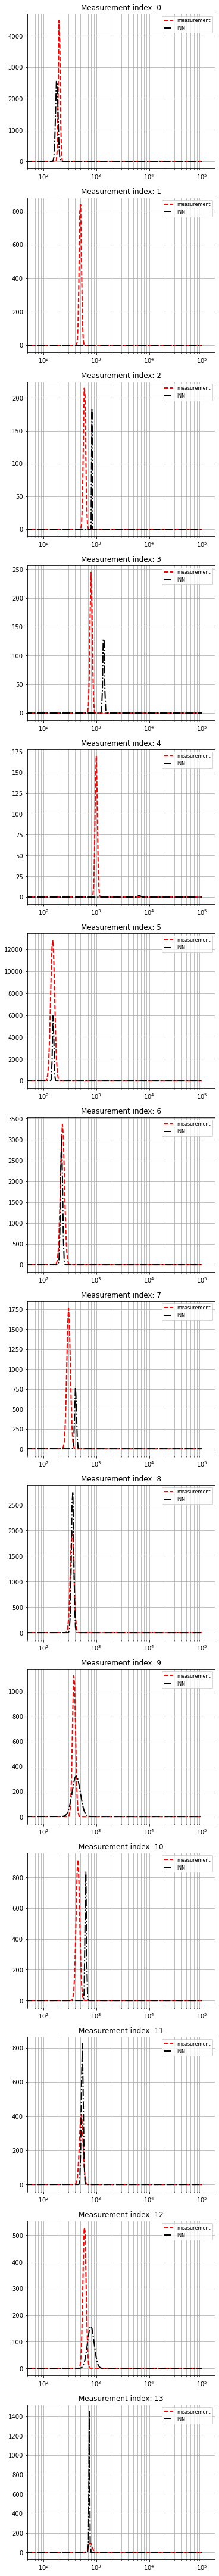

In [175]:
fig, axs = plt.subplots(ncols=1, nrows=14, figsize=(5, 60), constrained_layout=True)

for index in range(14):
    param_tmp = dvar_test1.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    axs[index].plot(D_array, lognormal(D_array,DmedianN_tmp,GSD_tmp,Ntot_tmp ), c='r', ls='--', lw=2, label='measurement')
                    
                    
    param_tmp_pred = dvar_t1_2predict.iloc[index]
    DmedianV_tmp_pred = param_tmp_pred['RmedianV']*2  # [um]
    GSD_tmp_pred = param_tmp_pred['GSD']
    Vtot_tmp_pred = param_tmp_pred['Vtot']
    DmedianN_tmp_pred = (np.exp(np.log(DmedianV_tmp_pred) - (3*np.log(GSD_tmp_pred)**2))) *1e3   # [nm]
    Ntot_tmp_pred = 6 / np.pi * Vtot_tmp_pred*1e9 / (np.exp((3*np.log(DmedianN_tmp_pred)) + (4.5*np.log(GSD_tmp_pred)**2))) # [cm^-3]
    axs[index].plot(D_array, lognormal(D_array,DmedianN_tmp_pred,GSD_tmp_pred,Ntot_tmp_pred ),ls='-.', c='k', lw=2, label='INN')
    axs[index].set_xscale('log')
    axs[index].legend(fontsize=8)
    axs[index].set_xlim(50, )
    axs[index].grid(which='both')
    axs[index].set_title('Measurement index: '+str(index)) 
fig.savefig(f'{plot_dir}/pymiescatt_measurements_size_distr.jpg')


In [ ]:
#pymiescatt_df = pd.DataFrame(columns = newcolumns)
#pymiescatt_df

In [ ]:
'''for index in range(14):
    param_tmp = dvar_test1.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    pms_hdf = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, theta, D_array)
    pymiescatt_df.loc[index]=np.concatenate([pms_hdf['F11'].T.values,pms_hdf['PPF'].T.values])
'''  

In [ ]:
#dvar_test2 = pd.DataFrame(columns = dvar_test1.columns)
#for i in range(14):
#    dvar_test2.loc[i] = pd.to_numeric(dvar_test1.loc[i])

In [ ]:
#dvar_test2.to_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5',key='dvar')    
#pymiescatt_df.to_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5',key='qoi')

In [ ]:
pymiescatt_df[F11_list]

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)

for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[index,0].plot(theta, pymiescatt_df[F11_newcolumns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_hdf_plot, = axs[index,1].plot(theta, pymiescatt_df[PPF_newcolumns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_hdf_plot, = axs[index,0].plot(theta_meas, qoi_test1[F11_list_test].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_hdf_plot, = axs[index,1].plot(theta_meas, qoi_test1[PPF_list_test].loc[index].values, c= 'b', label = 'uneph')

    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/pymiescatt_measurements.jpg')

In [ ]:
plot_dir

In [ ]:
pms_hdf['F11']

# Mean absolute error and Mean absolute percentage error

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

In [ ]:
MAE_all_dvar = []
MAPE_all_dvar = []
for col in dvar_test.keys():
    MAE = mean_absolute_error(dvar_test[col],dvar_pred_iv[col])
#    MAPE = mean_absolute_percentage_error(dvar_test[col],dvar_pred_iv[col])*100
    MAE_all_dvar.append(MAE)
#    MAPE_all_dvar.append(MAPE)
    print(col,'MAE: ***',MAE)#,'MAPE in % ***', MAPE)
MAE_all_dvar = np.array(MAE_all_dvar)
#MAPE_all_dvar = np.array(MAPE_all_dvar)

In [ ]:
MAE_all_dvar = pd.DataFrame([MAE_all_dvar],index = ['MAE_dvar'],columns = dvar_columns)
MAE_all_dvar

In [ ]:
#MAPE_all_dvar = pd.DataFrame([MAPE_all_dvar], index = ['MAPE_dvar'], columns = dvar_columns)
#MAPE_all_dvar

In [ ]:
MAE_all_qoi = []
#MAPE_all_qoi = []
for col in qoi_test.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred_fw[col])
#    MAPE = mean_absolute_percentage_error(qoi_test[col],qoi_pred_fw[col])

    MAE_all_qoi.append(MAE)
#    MAPE_all_qoi.append(MAPE)
    
    print(col,'MAE: ', MAE,'***')#, 'MAPE',MAPE)
MAE_all_qoi = np.array(MAE_all_qoi)
#MAPE_all_qoi = np.array(MAPE_all_qoi)

In [ ]:
MAE_all_qoi

In [ ]:
MAE_all_qoi = pd.DataFrame([MAE_all_qoi],index = ['MAE_qoi'],columns = qoi_columns)
MAE_all_qoi

In [ ]:
MAE_all_qoi.max(axis = 1)

In [ ]:
#MAPE_all_qoi = pd.DataFrame([MAPE_all_qoi],index = ['MAPE_qoi'],columns = qoi_columns)
#MAPE_all_qoi

In [ ]:
#MAPE_all_qoi.sort_values(by = ['MAPE_qoi'], axis = 1, ascending = False)

In [ ]:
#MAPE_all_qoi.max(axis = 1)

In [ ]:
MAE_all_qoi.mean(axis = 1)

In [ ]:
#MAPE_all_qoi.mean(axis = 1)

# Root mean squared error


RMSE = $\frac{1}{n_s}\sum^{n_s}_{i=0}{(y^i_{true}-y^i_{pred})^2}$ 





In [ ]:
RMSE_dvar = []
for col in dvar_test.keys():
    RMSE = np.sqrt(mean_squared_error(dvar_test[col],dvar_pred_iv[col]))
    #col_mean = dvar_test[col].mean()
    #col_p = MAE / col_mean *100
    RMSE_dvar.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_dvar = pd.DataFrame(RMSE_dvar,index = dvar_test.keys()).T

In [ ]:
RMSE_dvar

In [ ]:
RMSE_qoi = []
for col in qoi_test.keys():
    RMSE = np.sqrt(abs(mean_squared_error(qoi_test[col],qoi_pred_fw[col])))
#    col_mean = qoi_test[col].mean()
#    col_p = MAE / col_mean *100
    RMSE_qoi.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_qoi = np.array(RMSE_qoi)


In [ ]:
RMSE_qoi = pd.DataFrame([RMSE_qoi], columns = qoi_columns)

In [ ]:
RMSE_qoi.apply(pd.DataFrame.describe, axis = 1)


# explained variance score


EVS = $1- \frac{VAR(y_{true}-y_{pred})}{VAR(y_{true})}$


VAR = $\frac{1}{n}\sum^{n}_{i=1}{(y - \bar{y})}$

In [ ]:
EVS_dvar = []
for col in dvar_test.keys():
    EVS = explained_variance_score(dvar_test[col],dvar_pred_iv[col])
    EVS_dvar.append(EVS)
EVS_dvar = pd.DataFrame(EVS_dvar,index = dvar_test.keys()).T
EVS_dvar

In [ ]:
EVS_all = []
for col in qoi_test.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred_fw[col])
    print(col,'***',EVS)
    EVS_all.append(EVS)


In [ ]:
EVS_all_df = pd.DataFrame(EVS_all).T
EVS_all_df.columns = qoi_test.columns
EVS_all_df

In [ ]:
EVS_all_df.sort_values(by=EVS_all_df.index[0], axis = 1,ascending=True)


In [ ]:
EVS_all_df.apply(pd.DataFrame.describe,axis = 1)

# Plots
## qoi

In [80]:
#presentation_plot_index = [0,1000,2000,5000,6000] 
presentation_plot_index = [0,1000,2000,5000,6000,8000,10000] 

In [81]:
F11_532_columns
PPF_532_columns

['PPF_10',
 'PPF_11',
 'PPF_12',
 'PPF_13',
 'PPF_14',
 'PPF_15',
 'PPF_16',
 'PPF_17',
 'PPF_18',
 'PPF_19',
 'PPF_20',
 'PPF_21',
 'PPF_22',
 'PPF_23',
 'PPF_24',
 'PPF_25',
 'PPF_26',
 'PPF_27',
 'PPF_28',
 'PPF_29',
 'PPF_30',
 'PPF_31',
 'PPF_32',
 'PPF_33',
 'PPF_34',
 'PPF_35',
 'PPF_36',
 'PPF_37',
 'PPF_38',
 'PPF_39',
 'PPF_40',
 'PPF_41',
 'PPF_42',
 'PPF_43',
 'PPF_44',
 'PPF_45',
 'PPF_46',
 'PPF_47',
 'PPF_48',
 'PPF_49',
 'PPF_50',
 'PPF_51',
 'PPF_52',
 'PPF_53',
 'PPF_54',
 'PPF_55',
 'PPF_56',
 'PPF_57',
 'PPF_58',
 'PPF_59',
 'PPF_60',
 'PPF_61',
 'PPF_62',
 'PPF_63',
 'PPF_64',
 'PPF_65',
 'PPF_66',
 'PPF_67',
 'PPF_68',
 'PPF_69',
 'PPF_70',
 'PPF_71',
 'PPF_72',
 'PPF_73',
 'PPF_74',
 'PPF_75',
 'PPF_76',
 'PPF_77',
 'PPF_78',
 'PPF_79',
 'PPF_80',
 'PPF_81',
 'PPF_82',
 'PPF_83',
 'PPF_84',
 'PPF_85',
 'PPF_95',
 'PPF_96',
 'PPF_97',
 'PPF_98',
 'PPF_99',
 'PPF_100',
 'PPF_101',
 'PPF_102',
 'PPF_103',
 'PPF_104',
 'PPF_105',
 'PPF_106',
 'PPF_107',
 'PPF_108',
 

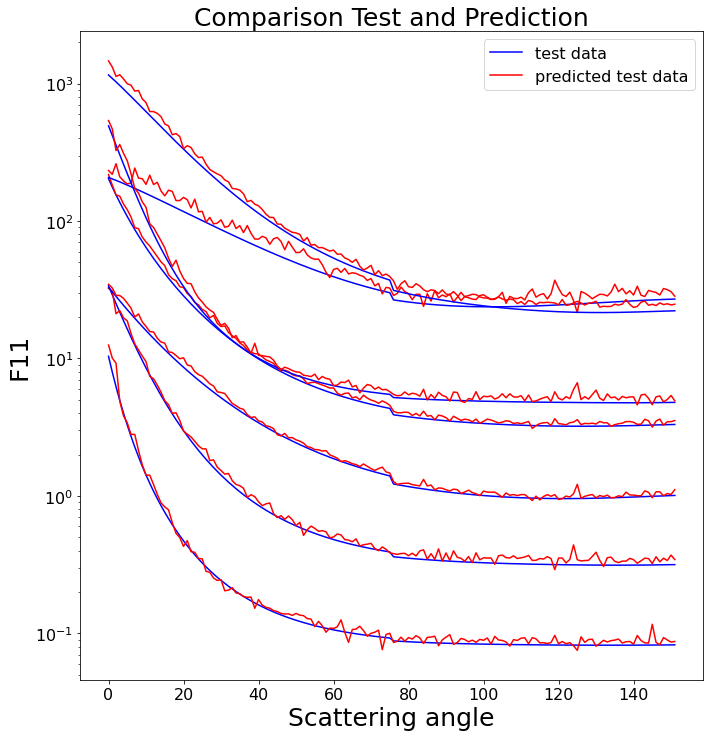

In [83]:

if len(F11_532_columns) != 0:
    fig, ax = plt.subplots(figsize = (10,10))
    for index in presentation_plot_index:
        ax.plot(np.arange(0,len(qoi_test_copy[F11_532_columns].iloc[index])),qoi_test_copy[F11_532_columns].iloc[index],'b')
        ax.plot(np.arange(0,len(qoi_test_copy[F11_532_columns].iloc[index])),qoi_pred_fw_copy[F11_532_columns].iloc[index],'r')

    ax.set_xlabel('Scattering angle',fontsize = 25)
    ax.set_ylabel('F11',fontsize = 25)
    ax.tick_params(labelsize = 16)    
    fig.tight_layout() 
    ax.set_yscale('log')
    ax.set_title( 'Comparison Test and Prediction',fontsize = 25)
    ax.legend(['test data', 'predicted test data'], fontsize = 16)
    fig.savefig(f'{plot_dir}/phase_function.jpg')

In [ ]:
presentation_plot_index=[0, 100, 200, 500, 600, 800, 10]

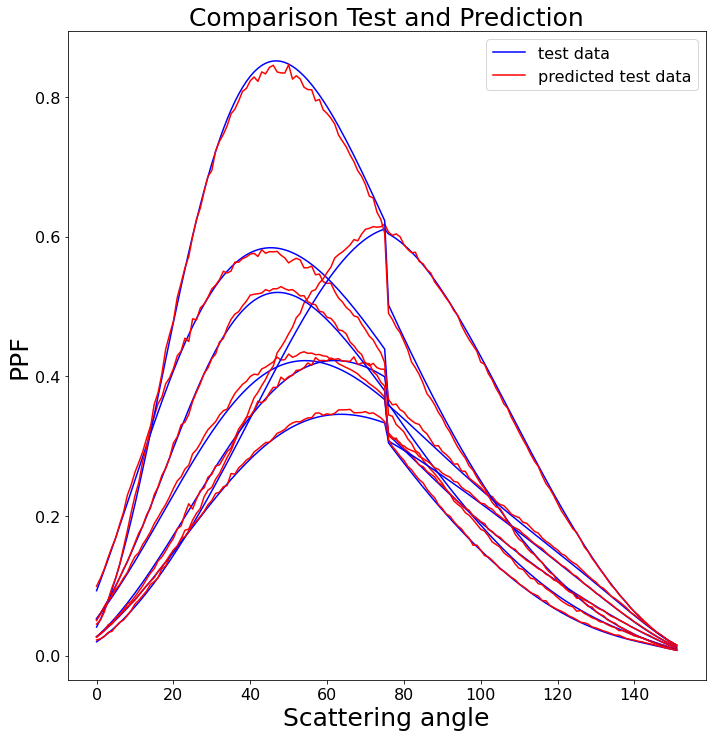

In [84]:

if len(F11_532_columns) != 0:
    fig, ax = plt.subplots(figsize = (10,10))
    for index in presentation_plot_index:
        ax.plot(np.arange(0,len(qoi_test[PPF_532_columns].iloc[index])),qoi_test[PPF_532_columns].iloc[index],'b')
        ax.plot(np.arange(0,len(qoi_test[PPF_532_columns].iloc[index])),qoi_pred_fw[PPF_532_columns].iloc[index],'r')



    ax.set_xlabel('Scattering angle',fontsize = 25)
    ax.set_ylabel('PPF',fontsize = 25)
    ax.tick_params(labelsize = 16)    
    fig.tight_layout() 
    ax.set_title( 'Comparison Test and Prediction',fontsize = 25)
    ax.legend(['test data', 'predicted test data'], fontsize = 16)
    fig.savefig(f'{plot_dir}/polarized_phase_function.jpg')

In [ ]:
dvar_pred_iv

In [85]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [86]:
dvar_test['DmedianV']=dvar_test['RmedianV']*2*1e-3 #[um]
dvar_test['DmedianN']=(np.exp(np.log(dvar_test['DmedianV']) - (3*np.log(dvar_test['GSD'])**2))) *1e3   #[nm]
dvar_test['Ntot'] = 6 / np.pi * dvar_test['Vtot']*1e9 / (np.exp((3*np.log(dvar_test['DmedianN'])) + (4.5*np.log(dvar_test['GSD'])**2))) # [cm^-3]
 

In [87]:
dvar_pred_iv['DmedianV']=dvar_pred_iv['RmedianV']*2*1e-3 #[um]
dvar_pred_iv['DmedianN']=(np.exp(np.log(dvar_pred_iv['DmedianV']) - (3*np.log(dvar_pred_iv['GSD'])**2))) *1e3 #[nm] 
dvar_pred_iv['Ntot'] = 6 / np.pi * dvar_pred_iv['Vtot']*1e9 / (np.exp((3*np.log(dvar_pred_iv['DmedianN'])) + (4.5*np.log(dvar_pred_iv['GSD'])**2))) # [cm^-3]


In [88]:
dvar_pred_iv

Vtot     RmedianV       GSD         n         k  DmedianV  \
0      2.218838   737.815076  1.868658  1.518697  1.577298  1.475630   
1      1.584088   449.414184  1.697140  2.629760  0.730467  0.898828   
2      2.288699  3002.132583  2.651826  2.092997  1.738897  6.004265   
3      3.250748   249.988581  1.024064  2.723015  0.925381  0.499977   
4      3.864826   524.034767  2.164872  2.409255  2.117648  1.048070   
...         ...          ...       ...       ...       ...       ...   
19995  7.936663   230.549703  2.073059  1.459631  0.464291  0.461099   
19996  1.317667   210.332077  1.188367  1.531145  1.035093  0.420664   
19997  2.153140   525.510502  1.926094  2.676703  1.809476  1.051021   
19998  7.769942   805.721061  2.538393  2.894589  0.528146  1.611442   
19999  4.432213   164.598424  2.638499  2.555004  1.136804  0.329197   

         DmedianN          Ntot  
0      456.750498      7.658472  
1      388.287493     14.673555  
2      346.158247      1.458775  
3      499.129775     49.801128  
4      175.051541     93.928466  
...           ...           ...  
19995   93.614038   1690.191951  
19996  384.707323     38.655223  
19997  289.599544     24.488364  
19998  119.299167    176.052012  
19999   19.545273  16401.211009  

[20000 rows x 8 columns]

In [89]:
dvar_test

Vtot     RmedianV       GSD         n         k  DmedianV  \
0      2.280593   740.955994  1.860629  1.509454  1.576845  1.481912   
1      1.600002   447.099789  1.687354  2.622790  0.754203  0.894200   
2      2.287829  2953.110936  2.635387  2.087974  1.787399  5.906222   
3      3.321433   254.587570  1.044152  2.913697  1.101197  0.509175   
4      3.892055   519.446422  2.185569  2.364048  2.055679  1.038893   
...         ...          ...       ...       ...       ...       ...   
19995  7.973462   244.818462  2.048755  1.459021  0.468698  0.489637   
19996  1.333215   204.348275  1.206468  1.562014  1.081841  0.408697   
19997  2.196189   528.078164  1.949690  2.689447  1.873984  1.056156   
19998  7.769406   780.091790  2.555797  2.806807  0.538075  1.560184   
19999  4.435587   168.632644  2.579873  2.563342  1.104086  0.337265   

         DmedianN          Ntot  
0      466.138682      7.586524  
1      393.403283     14.645809  
2      353.082987      1.450926  
3      506.331727     48.458877  
4      165.988835    103.802056  
...           ...           ...  
19995  104.626520   1313.331560  
19996  367.705460     43.706895  
19997  277.283470     26.466272  
19998  111.160634    205.446664  
19999   22.788008  12572.899999  

[20000 rows x 8 columns]

In [90]:
D_array = np.logspace(1, 4.5, 200)  # [nm]


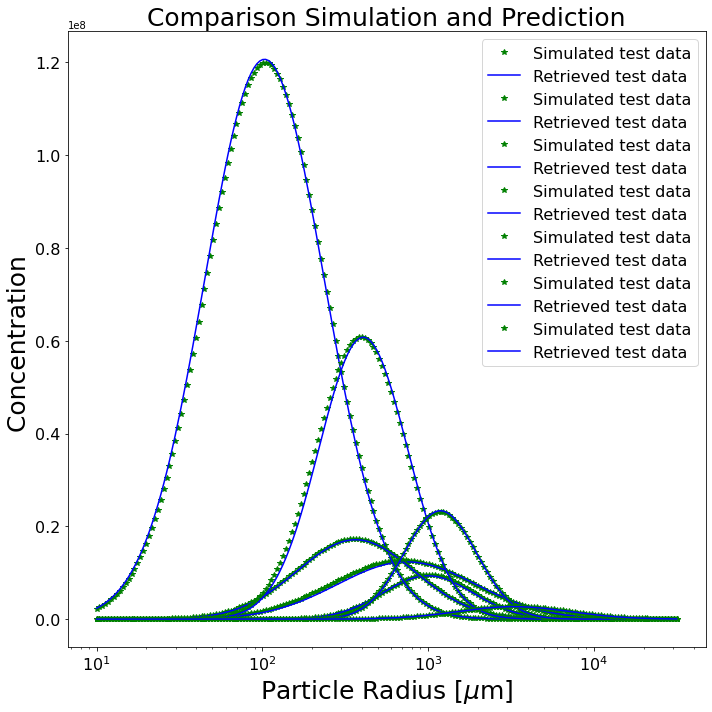

In [91]:
fig, ax = plt.subplots(figsize = (10,10))



for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, dvar_test['DmedianN'].loc[i], dvar_test['GSD'].loc[i], dvar_test['Ntot'].loc[i])
    pdf2 = lognormal(D_array, dvar_pred_iv['DmedianN'].loc[i], dvar_pred_iv['GSD'].loc[i], dvar_pred_iv['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*g', label = 'Simulated test data')
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., 'b', label = 'Retrieved test data')
    

    
ax.legend(['Predicted test data', 'test data'], fontsize = 16)
ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/GSD_GMR_iv.jpg')

In [180]:
dvar_pred_iv

Vtot     RmedianV       GSD         n         k  DmedianV  \
0      2.218838   737.815076  1.868658  1.518697  1.577298  1.475630   
1      1.584088   449.414184  1.697140  2.629760  0.730467  0.898828   
2      2.288699  3002.132583  2.651826  2.092997  1.738897  6.004265   
3      3.250748   249.988581  1.024064  2.723015  0.925381  0.499977   
4      3.864826   524.034767  2.164872  2.409255  2.117648  1.048070   
...         ...          ...       ...       ...       ...       ...   
19995  7.936663   230.549703  2.073059  1.459631  0.464291  0.461099   
19996  1.317667   210.332077  1.188367  1.531145  1.035093  0.420664   
19997  2.153140   525.510502  1.926094  2.676703  1.809476  1.051021   
19998  7.769942   805.721061  2.538393  2.894589  0.528146  1.611442   
19999  4.432213   164.598424  2.638499  2.555004  1.136804  0.329197   

         DmedianN          Ntot  
0      456.750498      7.658472  
1      388.287493     14.673555  
2      346.158247      1.458775  
3      499.129775     49.801128  
4      175.051541     93.928466  
...           ...           ...  
19995   93.614038   1690.191951  
19996  384.707323     38.655223  
19997  289.599544     24.488364  
19998  119.299167    176.052012  
19999   19.545273  16401.211009  

[20000 rows x 8 columns]

In [171]:
results_dataframe = pd.DataFrame(columns = ['F11','PPF','Vtot','RmedianV','GSD','n','k'], index = ['abs_err50%','abs_err75%','abs_err90%','abs_err95%','abs_err99%','rel_err50%','rel_err75%','rel_err90%','rel_err95%','rel_err99%','wmape','R2'])

In [178]:
results_dataframe['F11'].iloc[0:5]= abs_error_table_fw_F11.max(axis = 1)
results_dataframe['PPF'].iloc[0:5]= abs_error_table_fw_PPF.max(axis = 1)

results_dataframe['Vtot'].iloc[0:5]=abs_error_table_iv['Vtot']
results_dataframe['RmedianV'].iloc[0:5]=abs_error_table_iv['RmedianV']
results_dataframe['GSD'].iloc[0:5]=abs_error_table_iv['GSD']
results_dataframe['n'].iloc[0:5]=abs_error_table_iv['n']
results_dataframe['k'].iloc[0:5]=abs_error_table_iv['k']

results_dataframe['F11'].iloc[5:10]= rel_error_table_fw_F11.max(axis = 1)
results_dataframe['PPF'].iloc[5:10]= rel_error_table_fw_PPF.max(axis = 1)

results_dataframe['Vtot'].iloc[5:10]=rel_error_table_iv['Vtot']
results_dataframe['RmedianV'].iloc[5:10]=rel_error_table_iv['RmedianV']
results_dataframe['GSD'].iloc[5:10]=rel_error_table_iv['GSD']
results_dataframe['n'].iloc[5:10]=rel_error_table_iv['n']
results_dataframe['k'].iloc[5:10]=rel_error_table_iv['k']

results_dataframe['F11'].iloc[10]= np.round(wMAPE_qoi[F11_532_columns].mean().mean(), decimals = 2)
results_dataframe['PPF'].iloc[10]= np.round(wMAPE_qoi[PPF_532_columns].mean().mean(), decimals = 2)

results_dataframe['Vtot'].iloc[10]=np.round(wMAPE_dvar['Vtot'].values[0], decimals = 2)
results_dataframe['RmedianV'].iloc[10]=np.round(wMAPE_dvar['RmedianV'].values[0], decimals = 2)
results_dataframe['GSD'].iloc[10]=np.round(wMAPE_dvar['GSD'].values[0], decimals = 2)
results_dataframe['n'].iloc[10]=np.round(wMAPE_dvar['n'].values[0], decimals = 2)
results_dataframe['k'].iloc[10]=np.round(wMAPE_dvar['k'].values[0], decimals = 2)

results_dataframe['F11'].iloc[11]= np.round(r2_adj_fw[F11_532_columns].mean(axis = 1).values[0], decimals = 2)
results_dataframe['PPF'].iloc[11]= np.round(r2_adj_fw[PPF_532_columns].mean(axis = 1).values[0], decimals = 2)

results_dataframe['Vtot'].iloc[11]=r2_adj_iv['Vtot'].values[0]
results_dataframe['RmedianV'].iloc[11]=r2_adj_iv['RmedianV'].values[0]
results_dataframe['GSD'].iloc[11]=r2_adj_iv['GSD'].values[0]
results_dataframe['n'].iloc[11]=r2_adj_iv['n'].values[0]
results_dataframe['k'].iloc[11]=r2_adj_iv['k'].values[0]



In [179]:
results_dataframe

F11      PPF   Vtot RmedianV    GSD     n      k
abs_err50%    14.72     0.01   0.03    10.02   0.02  0.03   0.02
abs_err75%    191.1     0.01   0.06    45.63   0.05  0.05   0.05
abs_err90%   898.68     0.03    0.1   144.71   0.08  0.08    0.1
abs_err95%  1896.02     0.04   0.14   263.63   0.11  0.11   0.14
abs_err99%  5852.51     0.14   0.28   635.16    0.2  0.24    0.3
rel_err50%    19.51     7.57   0.81     1.81   1.18  1.21    2.9
rel_err75%     37.3     26.7   1.89     3.53   2.19  2.17   5.57
rel_err90%    71.31    97.45   5.21     6.41   3.64  3.49  10.66
rel_err95%   119.99   345.05  11.31     9.16    5.1  4.72   17.4
rel_err99%   267.89  2847.49  57.51    18.39  10.78  9.78  53.53
wmape         25.96     3.97   1.11     4.43   1.76  1.77   3.95
R2           -68.66     0.94    1.0     0.98   0.99  0.98   0.98

# plot correlation test data and predicted test data

In [ ]:
for index in presentation_plot_index:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(qoi_pred_fw.iloc[index],qoi_test.iloc[index],'g*')
    ax.plot(qoi_test.iloc[index],qoi_test.iloc[index],'r')
    ax.set_title('qoi'+str(index), fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

In [ ]:
for key in dvar_columns:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(dvar_test[key],dvar_pred_iv[key],".")
    ax.plot(dvar_test[key],dvar_test[key],"r")
    ax.set_title(key, fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

In [ ]:
for key in dvar_test.columns:
    dvar_test_help = dvar_test.sort_values(key)
    dvar_pred_iv_df_help = dvar_pred_iv.loc[dvar_test_help.index]

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.plot(np.arange(0,len(dvar_test_help)),dvar_test_help[key],'b.', markersize = '1')
    ax.plot(np.arange(0,len(dvar_pred_iv_df_help)),dvar_pred_iv_df_help[key],'r.', markersize = '1')
    ax.set_title(key, fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

# plot r2 for forward and inverse model

In [ ]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
ax.set_ylabel('r2_adj')

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

fig.savefig(f'{plot_dir}/invertible_model_fw_r2_adj.jpg')


In [ ]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj_iv,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/invertible_model_inv_r2_adj.jpg')



# Plot Relative Errors / Absolute errors

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_fw_F11,
            cmap='Reds',
           # annot=True,
           # linewidths=2.,
            vmin=0.,
            vmax=np.max(rel_error_table_fw_F11.max()),
           # annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)
ax.set_title('relative error P11', fontsize =25)
fig.tight_layout(rect=(0, 0, 1.05, 1))

fig.savefig(f'{plot_dir}/forward_rel_error_percentiles.jpg')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(abs_error_table_fw_PPF,
            cmap='Reds',
           # annot=True,
           # linewidths=2.,
            vmin=0.,
            vmax=np.max(abs_error_table_fw_PPF.max()),
           # annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)
ax.set_title('absolute error P11/P12', fontsize =25)
fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/forward_rel_error_percentiles.jpg')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_iv,
            cmap='Reds',
       #     annot=False,
            linewidths=2.,
            vmin=0.,
            vmax=np.max(rel_error_table_iv.max()),
      #      annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/invertible_sampling_rel_error_percentiles.jpg')


In [ ]:
# Rework plots below

In [ ]:
surr.model.summary()

In [ ]:
import keras
from keras.utils.vis_utils import plot_model

In [ ]:
plot_model(surr.model, show_shapes=False,show_layer_names=True,to_file = f'{plot_dir}/model_architecture_invertible.png')


In [ ]:
r2_adj_fw = r2_adj_fw.rename({0: 'r2_adj'}, axis='index')
r2_adj_iv = r2_adj_iv.rename({0: 'r2_adj'}, axis='index')


# create overview plot

In [ ]:
'''# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_fw.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
#sns.heatmap(to_plot_fw,
#            vmin=-1.,
#            vmax=1.,
#            linewidths = 0.01,
#            cmap='coolwarm',)
#plt.tick_params(labelsize = 16)
#plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_fw.columns)+3),qoi_pred_fw.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_fw.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_invertible_model_fw.jpg')
'''


In [ ]:
'''# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj_iv,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_iv,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_iv.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
#sns.heatmap(to_plot_iv,
#            vmin=-1.,
#            vmax=1.,
#            linewidths = 0.01,
#            cmap='coolwarm',)
#plt.tick_params(labelsize = 16)
#plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_fw.columns)+3),qoi_pred_fw.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_fw.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_invertible_model_iv.jpg')
'''


In [ ]:
configs = pd.read_csv(f'{model_dir}/configs.csv')
configs.columns

In [ ]:
store_results = pd.DataFrame()


In [ ]:
store_results['data_file'] = configs['config/datafile']
store_results['batch_size'] = configs['config/batch_size']
store_results['learning_rate'] = configs['config/learning_rate']
store_results['n_blocks'] = configs['config/n_blocks']
store_results['n_depth'] = configs['config/n_depth']
store_results['n_width'] = configs['config/n_width']
store_results['weight_x'] = configs['config/weight_x']
store_results['weight_y'] = configs['config/weight_y']
store_results['weight_z'] = configs['config/weight_z']
store_results['weight_artificial'] = configs['config/weight_artificial']
store_results['weight_reconstruction'] = configs['config/weight_reconstruction']
store_results['r2_val_qoi_mean'] = configs['r2_val']
store_results['r2_test_qoi_mean'] = r2_adj_fw.mean(axis =1).values
if 'P11' in qoi_columns[0]:
    store_results['rel_error95%_qoi_P11_max'] = rel_error_table_fw_P11.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P11_max'] = abs_error_table_fw_P11.max(axis = 1)['95%']
else:
    store_results['rel_error95%_qoi_P11_max'] = 0
    store_results['abs_error95%_qoi_P11_max'] = 0
if 'P12' in qoi_columns[-1]:
    store_results['rel_error95%_qoi_P12_max'] = rel_error_table_fw_P12.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P12_max'] = abs_error_table_fw_P12.max(axis = 1)['95%']
else:    
    store_results['rel_error95%_qoi_P12_max'] = 0
    store_results['rel_error95%_qoi_P12_max'] = 0
store_results['MAE_qoi_max'] = MAE_all_qoi.max(axis= 1).values
store_results['MAPE%_qoi_max'] = MAPE_all_qoi.max(axis= 1).values
store_results['explained_variance_qoi_min'] = EVS_all_df.min(axis = 1)

store_results['r2_val_dvar_mean'] = configs['r2_val_dvar']
store_results['r2_test_dvar_mean'] = r2_adj_iv.mean(axis = 1).values



store_results['r2_test_dvar_V'] = r2_adj_iv['V_tot']['r2_adj']
store_results['rel_error95%_dvar_V'] = rel_error_table_iv['V_tot']['95%']
store_results['abs_error95%_dvar_V'] = abs_error_table_iv['V_tot']['95%']
store_results['MAE_dvar_V'] = MAE_all_dvar['V_tot'].values
store_results['MAPE%_dvar_V'] = MAPE_all_dvar['V_tot'].values
store_results['explained_variance_dvar_V'] = EVS_dvar['V_tot']

store_results['r2_test_dvar_R'] = r2_adj_iv['R_median']['r2_adj']
store_results['rel_error95%_dvar_R'] = rel_error_table_iv['R_median']['95%']
store_results['abs_error95%_dvar_R'] = abs_error_table_iv['R_median']['95%']
store_results['MAE_dvar_R'] = MAE_all_dvar['R_median'].values
store_results['MAPE%_dvar_R'] = MAPE_all_dvar['R_median'].values
store_results['explained_variance_dvar_R'] = EVS_dvar['R_median']

store_results['r2_test_dvar_GSD'] = r2_adj_iv['GSD']['r2_adj']
store_results['rel_error95%_dvar_GSD'] = rel_error_table_iv['GSD']['95%']
store_results['abs_error95%_dvar_GSD'] = abs_error_table_iv['GSD']['95%']
store_results['MAE_dvar_GSD'] = MAE_all_dvar['GSD'].values
store_results['MAPE%_dvar_GSD'] = MAPE_all_dvar['GSD'].values
store_results['explained_variance_dvar_GSD'] = EVS_dvar['GSD']

if 'n' in dvar_columns:  
    store_results['r2_test_dvar_n'] = r2_adj_iv['n']['r2_adj']
    store_results['rel_error95%_dvar_n'] = rel_error_table_iv['n']['95%']
    store_results['abs_error95%_dvar_n'] = abs_error_table_iv['n']['95%']
    store_results['MAE_dvar_n'] = MAE_all_dvar['n'].values
    store_results['MAPE%_dvar_n'] = MAPE_all_dvar['n'].values
    store_results['explained_variance_dvar_n'] = EVS_dvar['n']
else:
    store_results['r2_test_dvar_n'] = 0
    store_results['rel_error95%_dvar_n'] = 0
    store_results['abs_error95%_dvar_n'] = 0
    store_results['MAE_dvar_n'] = 0
    store_results['MAPE%_dvar_n'] = 0
    store_results['explained_variance_dvar_n'] = 0   



if 'n_532nm' in dvar_columns:    
    store_results['r2_test_dvar_n_532'] = r2_adj_iv['n_532nm']['r2_adj']
    store_results['rel_error95%_dvar_n_532'] = rel_error_table_iv['n_532nm']['95%']
    store_results['abs_error95%_dvar_n_532'] = abs_error_table_iv['n_532nm']['95%']
    store_results['MAE_dvar_n_532'] = MAE_all_dvar['n_532nm'].values
    store_results['MAPE%_dvar_n_532'] = MAPE_all_dvar['n_532nm'].values
    store_results['explained_variance_dvar_n_532'] = EVS_dvar['n_532nm']

else:
    store_results['r2_test_dvar_n_532'] = 0
    store_results['rel_error95%_dvar_n_532'] = 0
    store_results['abs_error95%_dvar_n_532'] = 0
    store_results['MAE_dvar_n_532'] = 0
    store_results['MAPE%_dvar_n_532'] = 0
    store_results['explained_variance_dvar_n_532'] = 0


if 'k_532nm' in dvar_columns:    
    store_results['r2_test_dvar_k_532'] = r2_adj_iv['k_532nm']['r2_adj']
    store_results['rel_error95%_dvar_k_532'] = rel_error_table_iv['k_532nm']['95%']
    store_results['abs_error95%_dvar_k_532'] = abs_error_table_iv['k_532nm']['95%']
    store_results['MAE_dvar_k_532'] = MAE_all_dvar['k_532nm'].values
    store_results['MAPE%_dvar_k_532'] = MAPE_all_dvar['k_532nm'].values
    store_results['explained_variance_dvar_k_532'] = EVS_dvar['k_532nm']

else:
    store_results['r2_test_dvar_k_532'] = 0
    store_results['rel_error95%_dvar_k_532'] = 0
    store_results['abs_error95%_dvar_k_532'] = 0
    store_results['MAE_dvar_k_532'] = 0
    store_results['MAPE%_dvar_k_532'] = 0
    store_results['explained_variance_dvar_k_532'] = 0
    
if 'n_450nm' in dvar_columns:  
    store_results['r2_test_dvar_n_450'] = r2_adj_iv['n_450nm']['r2_adj']
    store_results['rel_error95%_dvar_n_450'] = rel_error_table_iv['n_450nm']['95%']
    store_results['abs_error95%_dvar_n_450'] = abs_error_table_iv['n_450nm']['95%']
    store_results['MAE_dvar_n_450'] = MAE_all_dvar['n_450nm'].values
    store_results['MAPE%_dvar_n_450'] = MAPE_all_dvar['n_450nm'].values
    store_results['explained_variance_dvar_n_450'] = EVS_dvar['n_450nm']
    
else:
    store_results['r2_test_dvar_n_450'] = 0
    store_results['rel_error95%_dvar_n_450'] = 0
    store_results['abs_error95%_dvar_n_450'] = 0
    store_results['MAE_dvar_n_450'] = 0
    store_results['MAPE%_dvar_n_450'] = 0
    store_results['explained_variance_dvar_n_450'] = 0
    
if 'k_450nm' in dvar_columns:  
    store_results['r2_test_dvar_k_450'] = r2_adj_iv['k_450nm']['r2_adj']
    store_results['rel_error95%_dvar_k_450'] = rel_error_table_iv['k_450nm']['95%']
    store_results['abs_error95%_dvar_k_450'] = abs_error_table_iv['k_450nm']['95%']
    store_results['MAE_dvar_k_450'] = MAE_all_dvar['k_450nm'].values
    store_results['MAPE%_dvar_k_450'] = MAPE_all_dvar['k_450nm'].values
    store_results['explained_variance_dvar_k_450'] = EVS_dvar['k_450nm']
    
else:
    store_results['r2_test_dvar_k_450'] = 0
    store_results['rel_error95%_dvar_k_450'] = 0
    store_results['abs_error95%_dvar_k_450'] = 0
    store_results['MAE_dvar_k_450'] = 0
    store_results['MAPE%_dvar_k_450'] = 0
    store_results['explained_variance_dvar_k_450'] = 0
    
if 'n_630nm' in dvar_columns:    
    store_results['r2_test_dvar_n_630'] = r2_adj_iv['n_630nm']['r2_adj']
    store_results['rel_error95%_dvar_n_630'] = rel_error_table_iv['n_630nm']['95%']
    store_results['abs_error95%_dvar_n_630'] = abs_error_table_iv['n_630nm']['95%']
    store_results['MAE_dvar_n_630'] = MAE_all_dvar['n_630nm'].values
    store_results['MAPE%_dvar_n_630'] = MAPE_all_dvar['n_630nm'].values
    store_results['explained_variance_dvar_n_630'] = EVS_dvar['n_630nm']
else:
    store_results['r2_test_dvar_n_630'] = 0
    store_results['rel_error95%_dvar_n_630'] = 0
    store_results['abs_error95%_dvar_n_630'] = 0
    store_results['MAE_dvar_n_630'] =0
    store_results['MAPE%_dvar_n_630'] =0
    store_results['explained_variance_dvar_n_630'] = 0
      
    
if 'k_630nm' in dvar_columns:    
    store_results['r2_test_dvar_k_630'] = r2_adj_iv['k_630nm']['r2_adj']
    store_results['rel_error95%_dvar_k_630'] = rel_error_table_iv['k_630nm']['95%']
    store_results['abs_error95%_dvar_k_630'] = abs_error_table_iv['k_630nm']['95%']
    store_results['MAE_dvar_k_630'] = MAE_all_dvar['k_630nm'].values
    store_results['MAPE%_dvar_k_630'] = MAPE_all_dvar['k_630nm'].values
    store_results['explained_variance_dvar_k_630'] = EVS_dvar['k_630nm']
else:
    store_results['r2_test_dvar_k_630'] = 0
    store_results['rel_error95%_dvar_k_630'] = 0
    store_results['abs_error95%_dvar_k_630'] = 0
    store_results['MAE_dvar_k_630'] =0
    store_results['MAPE%_dvar_k_630'] =0
    store_results['explained_variance_dvar_k_630'] = 0
    







store_results['preprocessor_x'] = configs['config/preprocessor_x']
store_results['preprocessor_y'] = configs['config/preprocessor_y']

In [ ]:
store_results.to_csv(f'{model_dir}/results_summary1.csv')


In [ ]:
store_results

In [ ]:
model_dir

In [ ]:
dvar_pred_iv[dvar_pred_iv['k']<0]

In [181]:
test_datafile

'/data/project/general/aerosolretriev/aerosol_data/dataset_08_11_2022/data_all_test_iv.h5'

In [182]:
model_dir

'/data/project/general/aerosolretriev/aerosol_results_november_2022/results_08_11_2022/invertible_model1_ds_08_11/models'

In [189]:
qoi_pred_fw_copy

F11_10       F11_11       F11_12       F11_13       F11_14  \
0        32.363068    30.806185    21.173798    22.330569    19.782028   
1        22.989542    20.274372    16.491795    16.234305    14.873596   
2         7.861822     6.159814     4.930945     4.313466     3.785436   
3       253.793483   119.816920    89.386136   136.491137   121.725750   
4       179.325146   161.679550   129.438033   141.304228   128.646772   
...            ...          ...          ...          ...          ...   
19995  9885.831916  9174.557272  9836.361967  6902.178667  6680.142624   
19996    15.788024    10.841508    11.223641    12.230384    11.828723   
19997    33.267785    29.823713    23.879502    25.169532    23.139175   
19998  6418.338225  5639.955415  5549.306895  4937.086148  4480.925350   
19999   263.440871   242.421670   247.220849   226.258496   213.769164   

            F11_15       F11_16       F11_17       F11_18       F11_19  ...  \
0        18.780948    15.173169    12.778927    11.553583    10.421677  ...   
1        14.194726    11.349163     9.330676    10.270613     8.657075  ...   
2         3.193280     2.667276     2.085582     1.934792     1.671789  ...   
3       298.547614   121.005175   445.159776   169.530638   109.353222  ...   
4       128.791039   109.853218    85.349904    90.159994    80.509241  ...   
...            ...          ...          ...          ...          ...  ...   
19995  6012.947847  5935.734568  8202.633012  6245.941196  6367.043088  ...   
19996    18.090914     9.979280     9.374433    10.479728    11.227354  ...   
19997    23.447229    18.647000    14.430913    15.482112    14.393504  ...   
19998  3919.001646  3384.855401  3193.485335  3020.842049  2537.475499  ...   
19999   203.733428   198.738018   209.108775   201.962142   188.021756  ...   

        PPF_161   PPF_162   PPF_163   PPF_164   PPF_165   PPF_166   PPF_167  \
0      0.025542  0.023289  0.021016  0.019202  0.017256  0.015609  0.014472   
1      0.033378  0.030236  0.028555  0.025653  0.022804  0.020809  0.018445   
2      0.017271  0.015631  0.014043  0.012556  0.011641  0.010007  0.008406   
3     -0.026368 -0.025028 -0.022154 -0.016553 -0.014174 -0.011612 -0.007683   
4      0.034986  0.032489  0.029629  0.027197  0.024157  0.021352  0.019036   
...         ...       ...       ...       ...       ...       ...       ...   
19995  0.062398  0.056651  0.050981  0.046421  0.041104  0.035859  0.030708   
19996  0.055194  0.051978  0.046115  0.040828  0.037170  0.030478  0.027995   
19997  0.030258  0.028011  0.026258  0.023929  0.021985  0.019623  0.017175   
19998  0.035959  0.033227  0.029431  0.026463  0.023267  0.020747  0.018280   
19999  0.050462  0.045298  0.041115  0.036088  0.032077  0.027711  0.023952   

        PPF_168   PPF_169   PPF_170  
0      0.011999  0.010551  0.009174  
1      0.016284  0.014245  0.012057  
2      0.007629  0.006947  0.005654  
3     -0.005240 -0.002075  0.000037  
4      0.016225  0.014197  0.011943  
...         ...       ...       ...  
19995  0.026433  0.022451  0.018733  
19996  0.021375  0.018126  0.014084  
19997  0.015289  0.012971  0.011306  
19998  0.015410  0.013484  0.011253  
19999  0.020565  0.017450  0.014706  

[20000 rows x 304 columns]

In [190]:
qoi_test_copy

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      3.520372  3.370919  3.223337  3.078055  2.935392  2.795585  2.658810   
1      2.993383  2.906044  2.816038  2.723926  2.630191  2.535254  2.439479   
2      2.083922  1.867308  1.665001  1.475370  1.297082  1.129031  0.970285   
3      4.631656  4.608993  4.584164  4.557170  4.528009  4.496681  4.463187   
4      5.166876  5.061900  4.958952  4.858128  4.759479  4.663025  4.568766   
...         ...       ...       ...       ...       ...       ...       ...   
19995  8.967994  8.912232  8.855130  8.796952  8.737918  8.678210  8.617980   
19996  2.485260  2.468145  2.449422  2.429098  2.407180  2.383675  2.358593   
19997  3.508680  3.401139  3.294218  3.188264  3.083539  2.980245  2.878532   
19998  8.758696  8.629973  8.506614  8.388176  8.274274  8.164572  8.058773   
19999  5.462620  5.418097  5.373526  5.329017  5.284647  5.240477  5.196556   

         F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0      2.525198  2.394844  2.267817  ...  0.025432  0.023474  0.021552   
1      2.343187  2.246660  2.150146  ...  0.032973  0.030442  0.027918   
2      0.820055  0.677661  0.542517  ...  0.018595  0.017020  0.015502   
3      4.427529  4.389708  4.349729  ...  0.033449  0.033608  0.033061   
4      4.476688  4.386768  4.298978  ...  0.034360  0.031700  0.029060   
...         ...       ...       ...  ...       ...       ...       ...   
19995  8.557358  8.496452  8.435355  ...  0.061744  0.055834  0.050172   
19996  2.331944  2.303737  2.273986  ...  0.058451  0.053110  0.047927   
19997  2.778518  2.680291  2.583919  ...  0.030253  0.028088  0.025911   
19998  7.956617  7.857872  7.762334  ...  0.033731  0.030741  0.027837   
19999  5.152917  5.109587  5.066588  ...  0.049745  0.044876  0.040226   

        PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0      0.019666  0.017814  0.015998  0.014222  0.012492  0.010814  0.009200  
1      0.025410  0.022931  0.020492  0.018108  0.015795  0.013569  0.011450  
2      0.014041  0.012637  0.011287  0.009990  0.008745  0.007557  0.006427  
3      0.031898  0.030215  0.028111  0.025682  0.023025  0.020230  0.017385  
4      0.026447  0.023871  0.021344  0.018878  0.016487  0.014186  0.011993  
...         ...       ...       ...       ...       ...       ...       ...  
19995  0.044766  0.039624  0.034753  0.030163  0.025863  0.021862  0.018169  
19996  0.042922  0.038115  0.033522  0.029164  0.025055  0.021213  0.017653  
19997  0.023727  0.021547  0.019380  0.017238  0.015136  0.013091  0.011119  
19998  0.025027  0.022317  0.019717  0.017235  0.014880  0.012662  0.010591  
19999  0.035801  0.031608  0.027653  0.023941  0.020478  0.017269  0.014319  

[20000 rows x 304 columns]

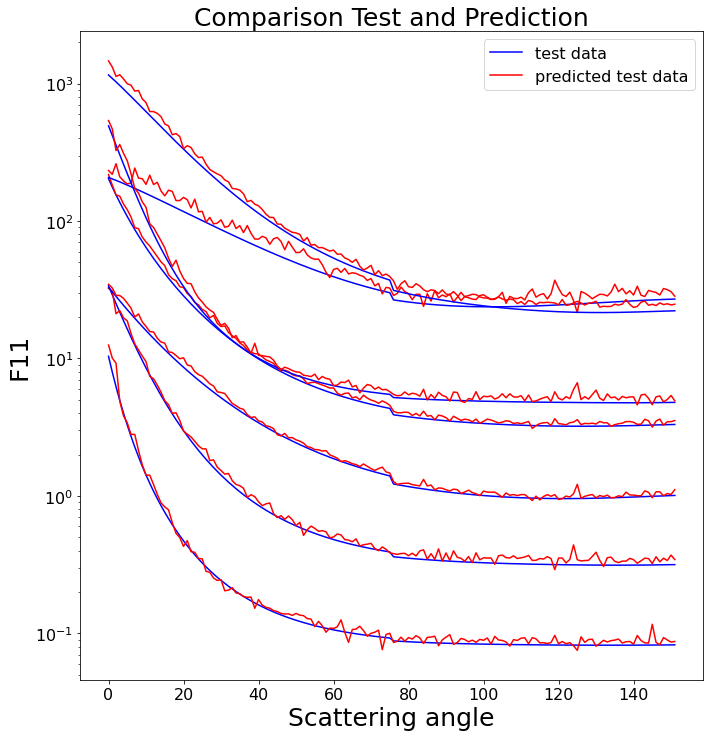

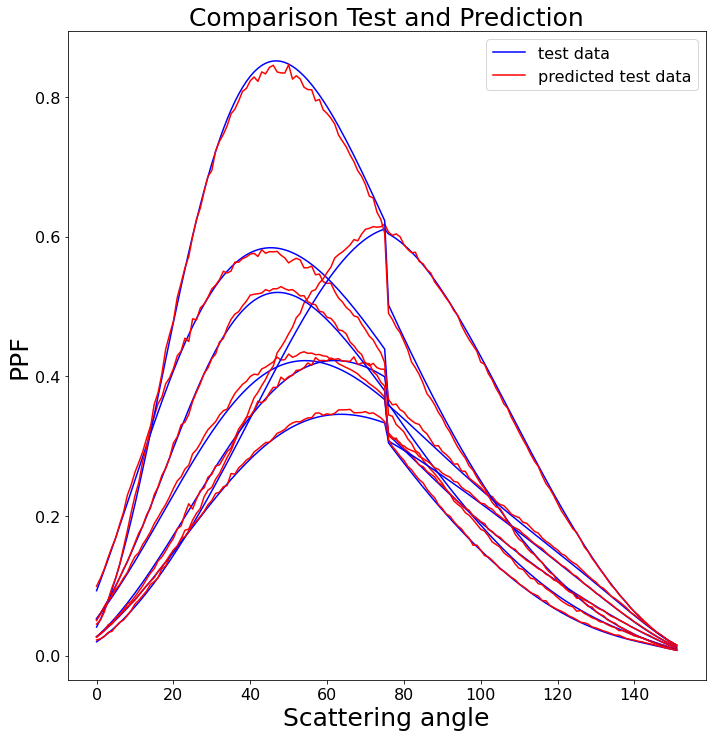

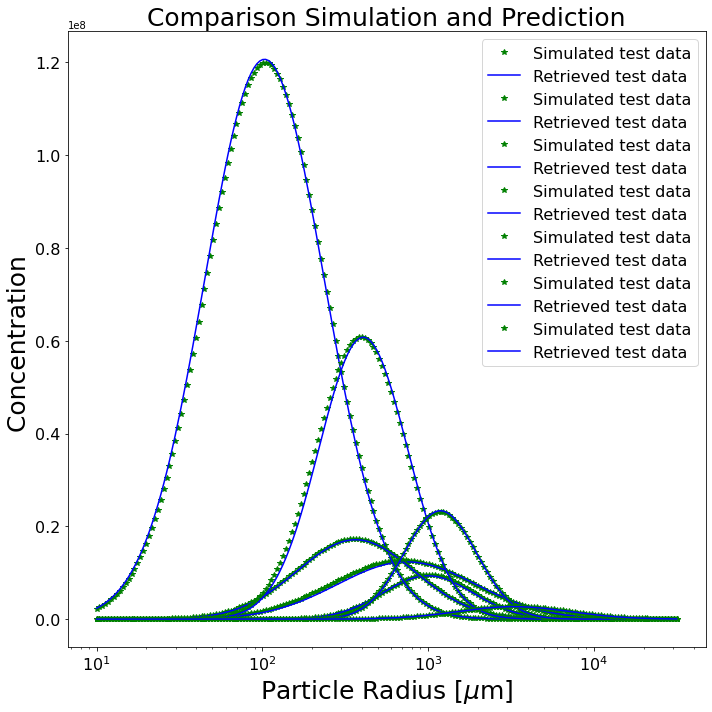

In [194]:
run analyze_invertible_model --test_file '/data/project/general/aerosolretriev/aerosol_data/dataset_08_11_2022/data_all_test_iv.h5' --directory '/data/project/general/aerosolretriev/aerosol_results_november_2022/results_08_11_2022/invertible_model1_ds_08_11/'
